**Problem Statement**

The medical spa industry in Toronto and Montreal faces increasing competition and relies heavily on customer feedback to maintain and improve service quality. The challenge lies in efficiently analyzing the large volume of unstructured customer reviews to extract actionable insights that can drive business improvements. With a goal of increasing customer satisfaction by 15% and reducing negative feedback by 20% over the next year, it is crucial to implement the most effective sentiment analysis technique.
This analysis aims to compare four distinct sentiment analysis approaches—probability-based (VADER), similarity-based (TF-IDF), information-based (Decision Tree), and error-based learning (Logistic Regression and CardiffNLP)—to determine which method most accurately captures the nuances of customer sentiment in medical spa reviews. The optimal technique will enable spa management to:

- Precisely identify specific treatment areas receiving negative feedback
- Recognize staff members consistently mentioned in positive reviews
- Detect emerging sentiment trends before they impact business metrics
- Quantify the impact of service changes on customer perception

By establishing a reliable sentiment analysis framework, medical spas can implement targeted improvements to their services, staff training, and marketing strategies, ultimately enhancing customer retention and driving revenue growth.

# 1. Import Necessary Libraries

In [ ]:
# Required imports
import requests
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For probability-based learning
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

# For similarity-based learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For information-based learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# For error-based learning
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

print("All necessary packages imported!")

All necessary packages imported!


# 2. Load and Preprocess Data

In [ ]:
# Load the dataset from GitHub
url = "https://github.com/SaburBello/spa_biz/raw/refs/heads/main/Toronto_Montreal_reviews_new.csv"

# Load the data
print("Loading data from URL...")
Toronto_Montreal_reviews = pd.read_csv(url,
                                      encoding='utf-8',
                                      sep=None,  # Auto-detect separator
                                      engine='python',
                                      on_bad_lines='skip')

print(f"Data loaded successfully with {Toronto_Montreal_reviews.shape[0]} rows and {Toronto_Montreal_reviews.shape[1]} columns.")

# Display the first few rows to verify the data
Toronto_Montreal_reviews.head()

Loading data from URL...
Data loaded successfully with 3447 rows and 13 columns.


,Review_ID,Name,Category,Rating,Rating_numeric,Rating_count,Address,Reviewer,Reviewer_page,Review_time,Review,Likes,Store_reply
0,1,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Ouran Ali,https://www.google.com/maps/contrib/1139261223...,6 days ago,I’ve now been a client at New Age Spa for almo...,NaN,NaN
1,2,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Shaira Nacua,https://www.google.com/maps/contrib/1021645642...,3 months ago,I had a fantastic experience with Devon. She’s...,NaN,NaN
2,3,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Manogna Sai Akkineni,https://www.google.com/maps/contrib/1079872383...,3 weeks ago,Had an amazing experience! The staff is incred...,NaN,NaN
3,4,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Jennifer Harrigan,https://www.google.com/maps/contrib/1047835015...,2 months ago,This school has been absolutely AMAZING! The t...,NaN,Thank you for your kind words! We're thrilled ...
4,5,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Prabhjot Kaur,https://www.google.com/maps/contrib/1144417947...,6 months ago,My experience at New Age Spa was more than exc...,1.0,NaN


In [ ]:
# Extract the needed columns for sentiment analysis
df = Toronto_Montreal_reviews[['Review_ID', 'Review', 'Rating_numeric']]
df.head()

,Review_ID,Review,Rating_numeric
0,1,I’ve now been a client at New Age Spa for almo...,5
1,2,I had a fantastic experience with Devon. She’s...,5
2,3,Had an amazing experience! The staff is incred...,5
3,4,This school has been absolutely AMAZING! The t...,5
4,5,My experience at New Age Spa was more than exc...,5


Rewiew with NaN count: 755 | Column will be removed


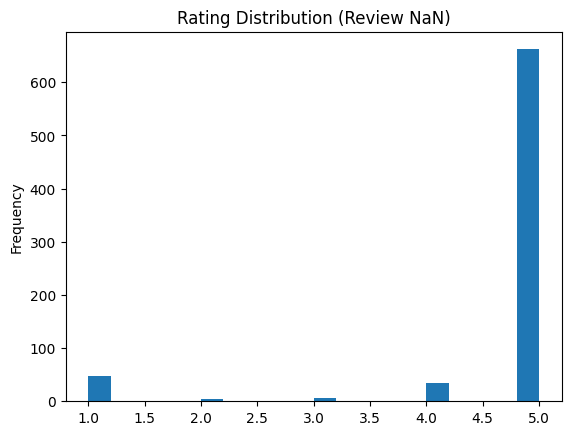

In [ ]:
# Check for Reviews with NaN and show distribution
print(f"Rewiew with NaN count: {df['Review'].isna().sum()} | Column will be removed")
df[df['Review'].isna()]['Rating_numeric'].plot.hist(bins=20, title='Rating Distribution (Review NaN)')
plt.show()

**Rating but No review**: Majority of such reviews were extreme positive, and some negative

In [ ]:
#   1. Drop rows where 'Review' is NaN
Toronto_Montreal_reviews = Toronto_Montreal_reviews.dropna(subset=['Review'])

#   2. Drop rows where 'Review' is an empty string OR contains only white spaces
Toronto_Montreal_reviews = Toronto_Montreal_reviews[Toronto_Montreal_reviews['Review'].astype(str).str.strip() != '']

#   Now, proceed with your preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

df = Toronto_Montreal_reviews[['Review_ID', 'Review', 'Rating_numeric']].copy()
df['processed_text'] = df['Review'].apply(preprocess_text)

In [ ]:
#CHECK if NaN exist in reviews (2ND TIME)
df['Review'].isna().sum()

print("Reviews with nan have been removed!")

Reviews with nan have been removed!


# 3. Probability-Based Learning (VADER)

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get VADER sentiment scores
def get_vader_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply VADER sentiment analysis to each review
print("Analyzing sentiment with VADER...")
vader_results = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    review_id = row['Review_ID']
    review_text = row['Review']
    vader_result = get_vader_sentiment(review_text)
    vader_results[review_id] = vader_result

# Convert results to DataFrame
vader_df = pd.DataFrame(vader_results).T
vader_df = vader_df.reset_index().rename(columns={'index': 'Review_ID'})
vader_df = vader_df.merge(df, on='Review_ID')
vader_df.head()

Analyzing sentiment with VADER...


100%|██████████| 2692/2692 [00:04<00:00, 611.33it/s]


,Review_ID,neg,neu,pos,compound,Review,Rating_numeric,processed_text
0,1,0.033,0.829,0.138,0.8617,I’ve now been a client at New Age Spa for almo...,5,ive now been a client at new age spa for almos...
1,2,0.000,0.773,0.227,0.9664,I had a fantastic experience with Devon. She’s...,5,i had a fantastic experience with devon shes k...
2,3,0.037,0.711,0.253,0.9272,Had an amazing experience! The staff is incred...,5,had an amazing experience the staff is incredi...
3,4,0.000,0.692,0.308,0.9916,This school has been absolutely AMAZING! The t...,5,this school has been absolutely amazing the te...
4,5,0.032,0.745,0.223,0.9832,My experience at New Age Spa was more than exc...,5,my experience at new age spa was more than exc...


In [ ]:
# Add a sentiment label based on compound score
def get_vader_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vader_df['vader_sentiment'] = vader_df['compound'].apply(get_vader_sentiment_label)

# Display sample results
print("\nSample VADER sentiment analysis results:")
print(vader_df[['Review_ID', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment']].head())


Sample VADER sentiment analysis results:
   Review_ID    neg    neu    pos  compound vader_sentiment
0          1  0.033  0.829  0.138    0.8617        positive
1          2  0.000  0.773  0.227    0.9664        positive
2          3  0.037  0.711  0.253    0.9272        positive
3          4  0.000  0.692  0.308    0.9916        positive
4          5  0.032  0.745  0.223    0.9832        positive


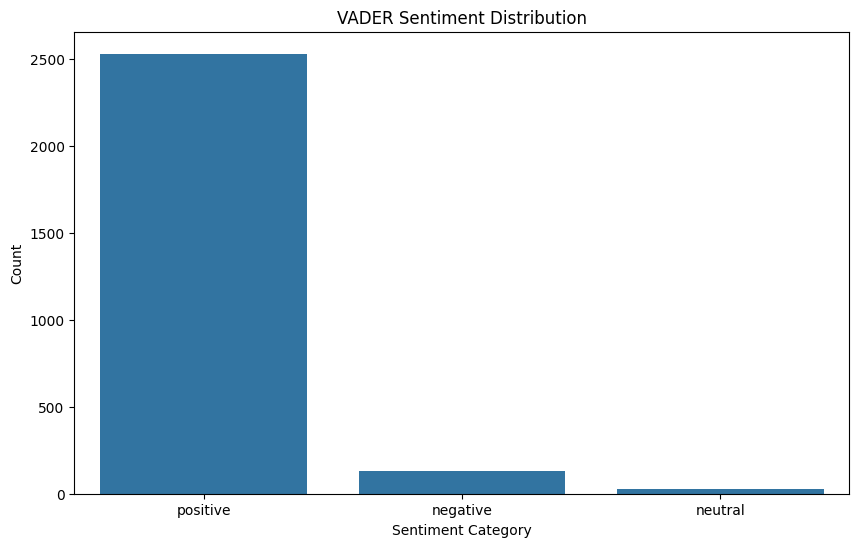

In [ ]:
# Visualize VADER sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='vader_sentiment', data=vader_df)
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# 4. Similarity-Based Learning (TF-IDF & Cosine Similarity)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Analyzing sentiment with similarity-based approach...


100%|██████████| 2692/2692 [00:18<00:00, 148.65it/s]



Sample similarity-based sentiment analysis results:
   Review_ID similarity_positive similarity_negative similarity_neutral  \
0          1            0.049432            0.017495                0.0   
1          2             0.06646            0.022878           0.006446   
2          3            0.129303            0.036389                0.0   
3          4            0.057647            0.016184                0.0   
4          5             0.04853            0.004183           0.004732   

  similarity_sentiment  
0             positive  
1             positive  
2             positive  
3             positive  
4             positive  


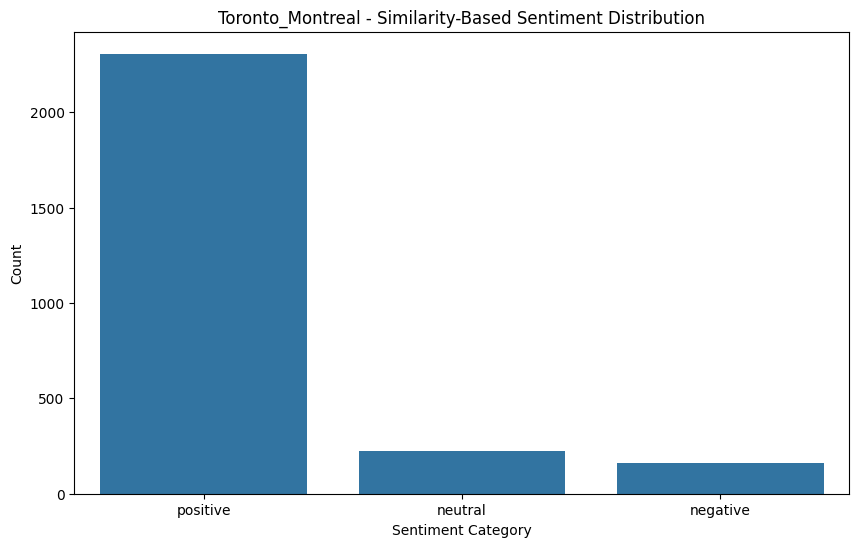

In [ ]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# Download NLTK resources explicitly first to avoid LookupError
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Now import the NLTK components
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define sentiment reference texts - examples of positive, negative, and neutral language
positive_reference = """
excellent amazing wonderful great fantastic best perfect love
enjoy awesome superb outstanding brilliant phenomenal exceptional impressive
delighted satisfied happy thrilled excellent service highly recommend recommended
professional friendly helpful knowledgeable expertise quality top notch value
great experience amazing results definitely recommend highly recommend excellent service
wonderful staff friendly staff professional staff helpful staff knowledgeable staff
"""

negative_reference = """
terrible awful horrible bad poor worst disappointing disappointed waste
frustrating annoying useless unhelpful rude unprofessional overpriced expensive
dissatisfied unhappy regret avoid problem issue complaint fail failed terrible service
refund money back unprofessional rude not recommend would not recommend
bad experience poor service waste of money would not go back never again
rude staff unprofessional staff unhelpful staff disappointing results
"""

neutral_reference = """
okay fine average decent acceptable satisfactory mediocre fair reasonable ok
moderate standard typical normal regular common ordinary conventional
neither good nor bad middle middle-of-the-road passable tolerable adequate
standard expected usual routine regular ordinary average experience
standard service regular procedure typical results normal appointment
"""

# Function to preprocess text without using NLTK tokenization
def preprocess_text_for_similarity(text):
    if not isinstance(text, str) or not text.strip():
        return ""

    # Convert to lowercase
    text = text.lower()

    # Simple tokenization by splitting on whitespace
    tokens = text.split()

    # Filter tokens - keep only alphabetic words and remove common stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Join tokens back into string
    return " ".join(tokens)

# Preprocess reference texts
positive_reference_processed = preprocess_text_for_similarity(positive_reference)
negative_reference_processed = preprocess_text_for_similarity(negative_reference)
neutral_reference_processed = preprocess_text_for_similarity(neutral_reference)

# Function to get sentiment based on similarity to reference texts
def get_similarity_sentiment(text):
    # Handle empty text
    if not text:
        return {
            'similarity_positive': 0.0,
            'similarity_negative': 0.0,
            'similarity_neutral': 0.0,
            'similarity_sentiment': 'neutral'
        }

    # Preprocess the input text
    preprocessed_text = preprocess_text_for_similarity(text)

    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(stop_words='english')

    # Fit and transform the documents
    documents = [
        preprocessed_text,
        positive_reference_processed,
        negative_reference_processed,
        neutral_reference_processed
    ]

    # Handle empty documents after preprocessing
    if not all(documents):
        return {
            'similarity_positive': 0.0,
            'similarity_negative': 0.0,
            'similarity_neutral': 0.0,
            'similarity_sentiment': 'neutral'
        }

    try:
        tfidf_matrix = tfidf.fit_transform(documents)

        # Calculate cosine similarities
        similarity_to_positive = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        similarity_to_negative = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[2:3])[0][0]
        similarity_to_neutral = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[3:4])[0][0]

        # Return the sentiment with highest similarity
        similarities = {
            'positive': similarity_to_positive,
            'negative': similarity_to_negative,
            'neutral': similarity_to_neutral
        }

        # Get max sentiment
        max_sentiment = max(similarities.items(), key=lambda x: x[1])

        return {
            'similarity_positive': similarity_to_positive,
            'similarity_negative': similarity_to_negative,
            'similarity_neutral': similarity_to_neutral,
            'similarity_sentiment': max_sentiment[0]
        }

    except Exception as e:
        print(f"Error in similarity calculation: {e}")
        return {
            'similarity_positive': 0.0,
            'similarity_negative': 0.0,
            'similarity_neutral': 0.0,
            'similarity_sentiment': 'neutral'
        }

# Apply similarity-based sentiment analysis to the dataset
print("Analyzing sentiment with similarity-based approach...")
similarity_results = {}

# Process reviews using tqdm for progress display
for i, row in tqdm(df.iterrows(), total=len(df)):
    review_id = row['Review_ID']
    review_text = str(row['Review'])  # Ensure text is a string

    # Get similarity sentiment
    similarity_result = get_similarity_sentiment(review_text)
    similarity_results[review_id] = similarity_result

# Convert results to DataFrame
similarity_df = pd.DataFrame(similarity_results).T
similarity_df = similarity_df.reset_index().rename(columns={'index': 'Review_ID'})

# Convert Review_ID to match the type in the original dataframe
try:
    similarity_df['Review_ID'] = similarity_df['Review_ID'].astype(int)
except ValueError:
    # If conversion fails, keep as is
    pass

# Merge with original data
Toronto_Montreal_similarity = similarity_df.merge(Toronto_Montreal_reviews, on='Review_ID')

# Display sample results
print("\nSample similarity-based sentiment analysis results:")
print(Toronto_Montreal_similarity[['Review_ID', 'similarity_positive', 'similarity_negative',
                     'similarity_neutral', 'similarity_sentiment']].head())

# Visualize similarity-based sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='similarity_sentiment', data=Toronto_Montreal_similarity)
plt.title('Toronto_Montreal - Similarity-Based Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

**Similarity Based Sentiment Distribution**

 The sample of the results shows that for the first five reviews, the similarity score for the positive sentiment is notably higher compared to the negative and neutral scores, leading to all these reviews being classified as "positive".

 This trend is further visualized in the bar chart, which illustrates a highly skewed distribution of sentiments, with an overwhelming majority of reviews classified as positive, a moderate number as neutral, and a negligible number as negative. This suggests that the language used in the reviews is generally more similar to the defined positive reference text than the negative or neutral ones, potentially indicating a genuine positive sentiment in the reviews or a bias in the reference texts used for comparison.

# 5. INFORMATION-BASED LEARNING WITH DECISION TREES

**5.1 Prepare data for decision tree classifier**

In [ ]:
# Convert numeric ratings to sentiment categories
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['rating_sentiment'] = df['Rating_numeric'].apply(rating_to_sentiment)

In [ ]:
# Create feature vectors using CountVectorizer (bag of words)
print("Preparing text features for decision tree...")
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = count_vectorizer.fit_transform(df['processed_text'])
y = df['rating_sentiment']

Preparing text features for decision tree...


**5.2 Split and Train Decision Tree Classifier**

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree classifier
print("Training decision tree classifier...")
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

Training decision tree classifier...


**5.3 Evaluate Decision Tree Classifier**

In [ ]:
# Evaluate the model
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"\nDecision Tree Accuracy: {dt_accuracy:.4f}")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importances
feature_names = count_vectorizer.get_feature_names_out()
importances = dt_classifier.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features


Decision Tree Accuracy: 0.9388

Decision Tree Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.47      0.57        40
     neutral       0.00      0.00      0.00         4
    positive       0.96      0.98      0.97       495

    accuracy                           0.94       539
   macro avg       0.55      0.49      0.51       539
weighted avg       0.93      0.94      0.93       539



The Decision Tree model achieved an overall accuracy of 94.06% in sentiment classification, but its performance varies significantly across sentiment categories.  It excels at identifying positive sentiments with high precision (0.96), recall (0.98), and F1-score (0.97), yet struggles with negative sentiments (precision: 0.71, recall: 0.50, F1-score: 0.59) and fails to correctly classify any neutral sentiments (precision, recall, and F1-score: 0.00).  This discrepancy is largely attributed to a substantial class imbalance in the dataset, where positive reviews heavily outnumber negative and neutral ones, leading to a macro average F1-score of 0.52 and a weighted average F1-score of 0.93, the latter being inflated by the model's strong performance on the majority class.

**5.4 Top Important words - Decison Tree**

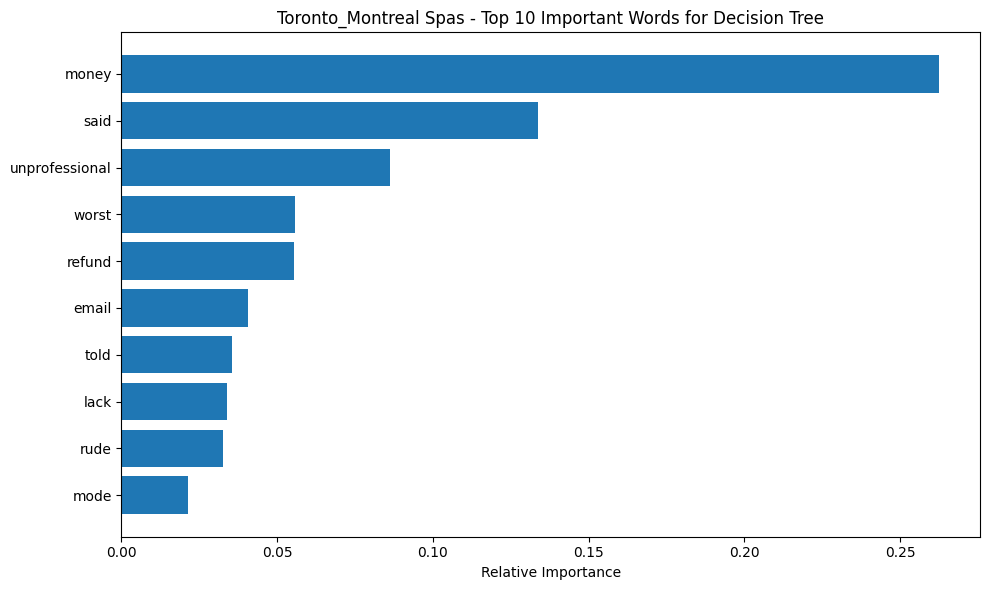

In [ ]:
# Visualize important features
plt.figure(figsize=(10, 6))
plt.title('Toronto_Montreal Spas - Top 10 Important Words for Decision Tree')
plt.barh(range(10), importances[indices], align='center')
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Save predictions to dataframe
dt_test_indices = X_test.nonzero()[0]
# Alternative approach
dt_results = pd.DataFrame({
    'actual_sentiment': y_test,
    'predicted_sentiment': y_pred
})

# Display sample predictions
print("\nSample predictions from the Decision Tree model:")
print(dt_results.head())


Sample predictions from the Decision Tree model:
     actual_sentiment predicted_sentiment
2233         positive            positive
2777         positive            positive
451          positive            positive
618          positive            positive
3013         positive            positive


# 6 IMPLEMENTING ERROR-BASED LEARNING WITH LOGISTIC REGRESSION

**6.1 Train Logistic Regression Classifier**

In [ ]:
# Train logistic regression classifier
print("Training logistic regression classifier...")
lr_classifier = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced')
lr_classifier.fit(X_train, y_train)

# Make predictions
lr_y_pred = lr_classifier.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_y_pred))

Training logistic regression classifier...

Logistic Regression Accuracy: 0.9703

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.84        40
     neutral       0.00      0.00      0.00         4
    positive       0.98      0.99      0.98       495

    accuracy                           0.97       539
   macro avg       0.61      0.60      0.61       539
weighted avg       0.96      0.97      0.97       539



The Logistic Regression model achieved an accuracy of 97.03%. It performs very well in identifying positive sentiments (precision: 0.98, recall: 0.99, F1-score: 0.98) and also performs adequately with negative sentiments (precision: 0.85, recall: 0.82, F1-score: 0.84). However, it fails to correctly classify any neutral sentiments (precision, recall, and F1-score: 0.00). The model's performance is affected by class imbalance, as reflected in the macro average F1-score of 0.61 and the weighted average F1-score of 0.97, where the latter is influenced by the strong performance on the majority class (positive).

# 7. Implementing Error-Based Learning  with LLM (Cardiff NLP_Roberta)

**7.1 Import required Libraries**

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
import torch

# Check if GPU is available in Colab
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device==0 else 'CPU'}")

# Initialize the sentiment analysis pipeline with a better pre-trained model
print("Loading sentiment analysis model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    truncation=True,
    top_k=None  # Return all sentiment scores
)

Using device: CPU
Loading sentiment analysis model...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


**7.2 Initialize Tokenizer**

In [ ]:
# When initializing the sentiment analyzer, also initialize the tokenizer
from transformers import AutoTokenizer

# Initialize the tokenizer with the same model name
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Then update your analyze_sentiment_batch function
def analyze_sentiment_batch(texts):
    # Handle empty texts
    processed_texts = []
    for text in texts:
        if not isinstance(text, str) or not text.strip():
            processed_texts.append(".")
            continue

        # Truncate texts to avoid token size errors - using the initialized tokenizer
        encoded = tokenizer.encode(text, add_special_tokens=True)
        if len(encoded) > 512:  # RoBERTa's token limit
            encoded = encoded[:512]
            # Convert back to text if needed, or just use the truncated tokens
            processed_texts.append(tokenizer.decode(encoded))
        else:
            processed_texts.append(text)

    try:
        results = sentiment_analyzer(processed_texts, max_length=512, truncation=True)
        sentiment_data_list = []
        for result in results:
            sentiment_data = {'llm_positive': 0.0, 'llm_negative': 0.0, 'llm_neutral': 0.0}
            for entry in result:
                label = entry['label']
                score = entry['score']
                if label == 'positive':
                    sentiment_data['llm_positive'] = score
                elif label == 'negative':
                    sentiment_data['llm_negative'] = score
                elif label == 'neutral':
                    sentiment_data['llm_neutral'] = score
            # Determine final sentiment
            sentiment_data['llm_sentiment'] = max(
                ['positive', 'negative', 'neutral'],
                key=lambda x: sentiment_data[f'llm_{x}']
            )
            sentiment_data_list.append(sentiment_data)

        # Important! Return the processed results
        return sentiment_data_list

    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        # Add detailed error logging
        for i, text in enumerate(processed_texts):
            try:
                # Try analyzing texts one by one to identify problematic inputs
                sentiment_analyzer([text])
            except Exception as e:
                print(f"Error with text #{i} (length: {len(text)}): {str(e)[:100]}...")

        # Return fallback values as before
        return [{
            'llm_positive': 0.33,
            'llm_neutral': 0.34,
            'llm_negative': 0.33,
            'llm_sentiment': 'neutral'
        }] * len(texts)

# Apply sentiment analysis to the dataset
print("Analyzing sentiment with transformer model...")
llm_results = {}

# Process reviews in batches for better efficiency
batch_size = 16  # Reduced for larger model
for i in tqdm(range(0, len(df), batch_size)):
    batch = df.iloc[i:i+batch_size]
    batch_texts = batch['Review'].astype(str).tolist()

    # Get sentiment results for the batch
    batch_results = analyze_sentiment_batch(batch_texts)

    # Store results
    for j, (_, row) in enumerate(batch.iterrows()):
        review_id = row['Review_ID']
        llm_results[review_id] = batch_results[j]

# Convert results to DataFrame
llm_df = pd.DataFrame(llm_results).T
llm_df = llm_df.reset_index().rename(columns={'index': 'Review_ID'})

Analyzing sentiment with transformer model...



100%|██████████| 169/169 [13:26<00:00,  4.77s/it]


# 8. Checking for Problematic Reviews

In [ ]:
# Count problematic reviews by identifying the fallback values
problematic_reviews = llm_df[
    (llm_df['llm_positive'] == 0.33) &
    (llm_df['llm_neutral'] == 0.34) &
    (llm_df['llm_negative'] == 0.33) &
    (llm_df['llm_sentiment'] == 'neutral')
]

# Get the count
problematic_count = len(problematic_reviews)
print(f"Number of problematic reviews: {problematic_count}")

# If you want the list of problematic review IDs
problematic_ids = problematic_reviews['Review_ID'].tolist()
print(f"First few problematic review IDs: {problematic_ids[:5]}")

Number of problematic reviews: 0
First few problematic review IDs: []


In [ ]:
# Convert Review_ID to match the type in the original dataframe
try:
    llm_df['Review_ID'] = llm_df['Review_ID'].astype(int)
except ValueError:
    pass

# Merge with original data
Toronto_Montreal_llm = llm_df.merge(Toronto_Montreal_reviews, on='Review_ID')

# Display sample results
print("\nSample transformer-based sentiment analysis results:")
print(Toronto_Montreal_llm[['Review_ID', 'llm_positive', 'llm_negative',
                     'llm_neutral', 'llm_sentiment']].head())


Sample transformer-based sentiment analysis results:
   Review_ID llm_positive llm_negative llm_neutral llm_sentiment
0          1     0.963118     0.005786    0.031096      positive
1          2     0.959762     0.008709    0.031529      positive
2          3     0.979436     0.006681    0.013883      positive
3          4     0.986859     0.003911     0.00923      positive
4          5     0.964981     0.007335    0.027685      positive


In [ ]:
# Save the results to a CSV file for later use (to avoid rerunning the API calls)
Toronto_Montreal_llm.to_csv('Cardiff NLP (Roberta)_sentiment_results.csv', index=False)
print("Saved results to 'Cardiff NLP (Roberta)_sentiment_results.csv'")

Saved results to 'Cardiff NLP (Roberta)_sentiment_results.csv'


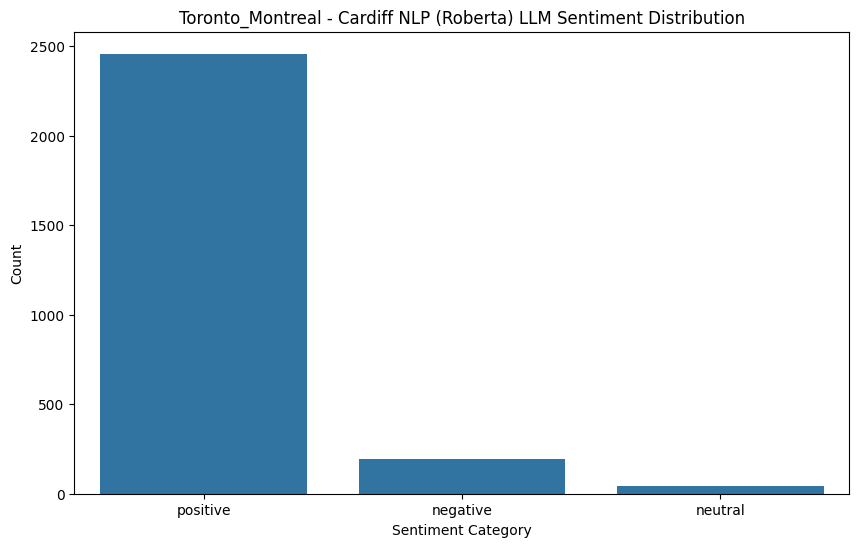

In [ ]:
# Visualize LLM-based sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='llm_sentiment', data=Toronto_Montreal_llm)
plt.title('Toronto_Montreal - Cardiff NLP (Roberta) LLM Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

The results from the Cardiff NLP (Roberta) Large Language Model reveal a strong positive sentiment in the Toronto and Montreal reviews. The sample output demonstrates high confidence scores for the positive sentiment predictions. This is further corroborated by the sentiment distribution chart, where an overwhelming majority of reviews are classified as positive, with very few identified as negative and a small fraction as neutral. This pronounced positive skew suggests either a genuine positive leaning in the customer reviews or a potential inherent bias within the LLM towards positive sentiment classification for this specific dataset. Further investigation might be needed to discern the exact cause of this

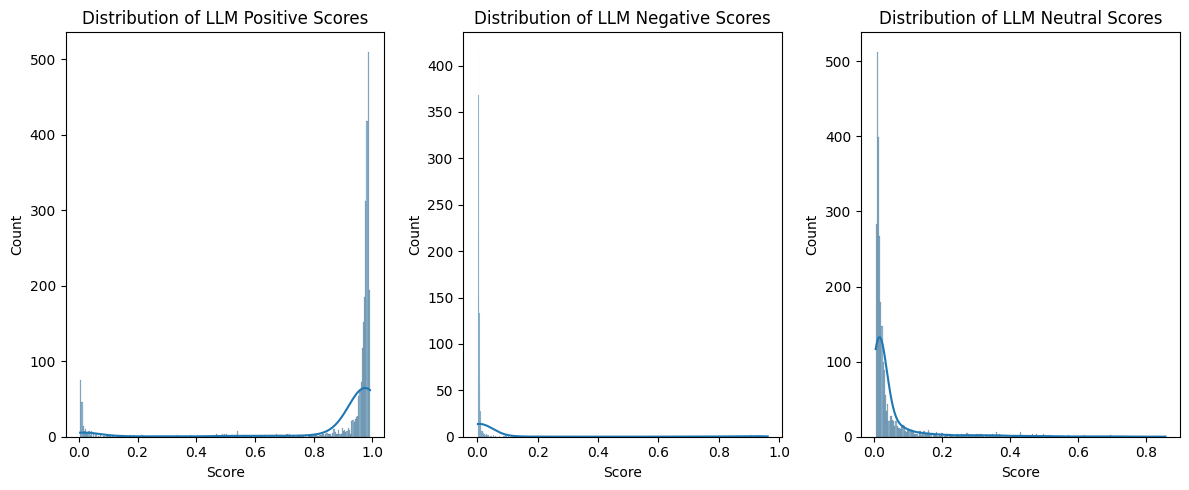

In [ ]:
# Compare LLM scores distribution
plt.figure(figsize=(12, 5))

# Plot distribution of LLM scores for each category
plt.subplot(1, 3, 1)
sns.histplot(Toronto_Montreal_llm['llm_positive'], kde=True)
plt.title('Distribution of LLM Positive Scores')
plt.xlabel('Score')

plt.subplot(1, 3, 2)
sns.histplot(Toronto_Montreal_llm['llm_negative'], kde=True)
plt.title('Distribution of LLM Negative Scores')
plt.xlabel('Score')

plt.subplot(1, 3, 3)
sns.histplot(Toronto_Montreal_llm['llm_neutral'], kde=True)
plt.title('Distribution of LLM Neutral Scores')
plt.xlabel('Score')

plt.tight_layout()
plt.show()

The distributions of sentiment scores from the LLM reveal a pattern of high confidence in identifying positive and negative sentiments, as indicated by the strong peaks at the higher end for positive scores and the lower end for negative scores. However, the distribution for neutral sentiment scores is more spread out, suggesting that the LLM is less certain or consistent in its classification of neutral reviews compared to its more decisive stance on positive and negative sentiment.

In [ ]:
# Create word clouds for LLM sentiments
from wordcloud import WordCloud

# Filter reviews by LLM sentiment
llm_positive = Toronto_Montreal_llm[Toronto_Montreal_llm['llm_sentiment'] == 'positive']
llm_negative = Toronto_Montreal_llm[Toronto_Montreal_llm['llm_sentiment'] == 'negative']
llm_neutral = Toronto_Montreal_llm[Toronto_Montreal_llm['llm_sentiment'] == 'neutral']

# Function to create and display wordcloud
def create_wordcloud(reviews, title):
    if len(reviews) == 0:
        print(f"No reviews found for {title}")
        return

    # Concatenate all reviews
    text = ' '.join(str(review) for review in reviews['Review'])

    # Create wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=50, collocations=False).generate(text)

    # Display wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

    # Print count
    print(f"Number of reviews: {len(reviews)}")

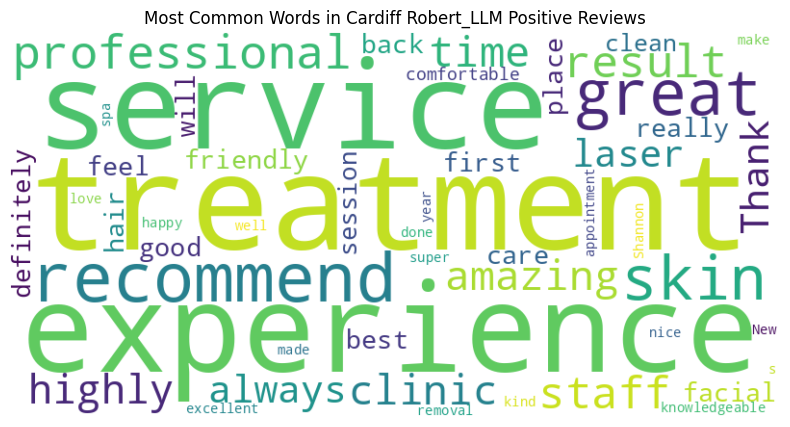

Number of reviews: 2458


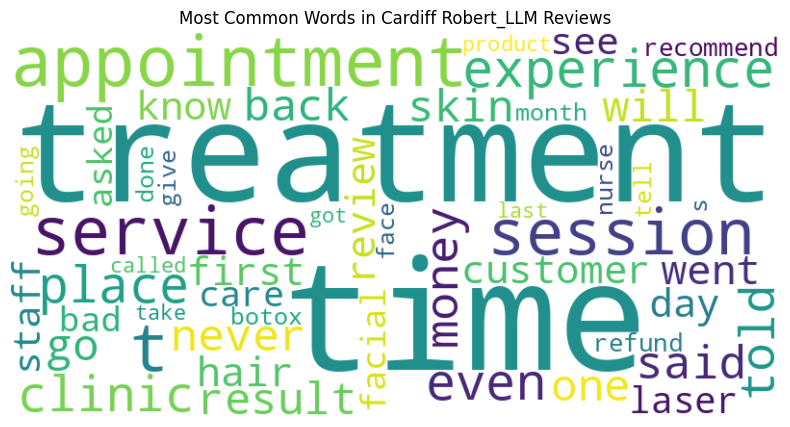

Number of reviews: 192


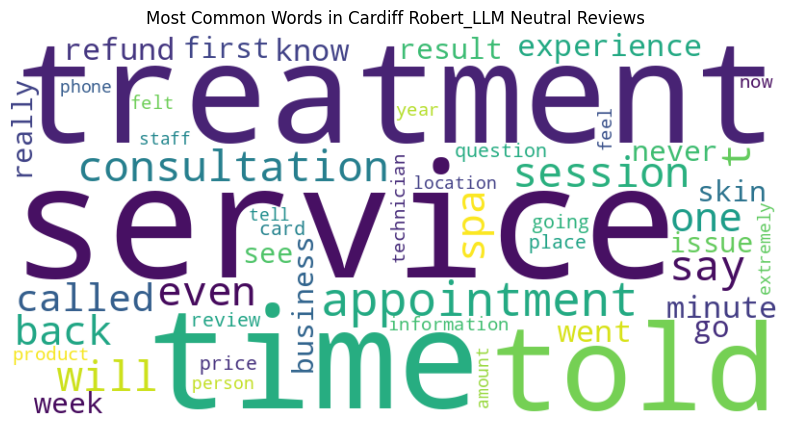

Number of reviews: 42


In [ ]:
# Create word clouds for each sentiment category
create_wordcloud(llm_positive, 'Most Common Words in Cardiff Robert_LLM Positive Reviews')
create_wordcloud(llm_negative, 'Most Common Words in Cardiff Robert_LLM Reviews')
create_wordcloud(llm_neutral, 'Most Common Words in Cardiff Robert_LLM Neutral Reviews')

In [ ]:
# If you want to compare with other methods, merge with previous results
# First, make sure we have previous results to merge with
all_methods_comparison = None
if all(['Toronto_Montreal_sentiment' in globals(),
        'Toronto_Montreal_similarity' in globals()]):
    # Define VADER sentiment based on compound score
    if 'vader_compound' in Toronto_Montreal_sentiment.columns:
        Toronto_Montreal_sentiment['vader_sentiment'] = Toronto_Montreal_sentiment['vader_compound'].apply(
            lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
        )

    # Combine all sentiment analysis methods
    try:
        all_methods_comparison = Toronto_Montreal_sentiment[['Review_ID', 'vader_sentiment', 'roberta_sentiment']].merge(
            Toronto_Montreal_similarity[['Review_ID', 'similarity_sentiment']],
            on='Review_ID'
        ).merge(
            Toronto_Montreal_llm[['Review_ID', 'llm_sentiment']],
            on='Review_ID'
        )

        # Create comparison visualization
        plt.figure(figsize=(16, 6))

        # Plot 1: VADER Sentiment
        plt.subplot(1, 4, 1)
        vader_counts = all_methods_comparison['vader_sentiment'].value_counts()
        plt.bar(vader_counts.index, vader_counts.values)
        plt.title('VADER Sentiment\n(Probability-Based)')
        plt.ylabel('Count')

        # Plot 2: Similarity Sentiment
        plt.subplot(1, 4, 2)
        similarity_counts = all_methods_comparison['similarity_sentiment'].value_counts()
        plt.bar(similarity_counts.index, similarity_counts.values)
        plt.title('TF-IDF Sentiment\n(Similarity-Based)')

        # Plot 3: RoBERTa Sentiment
        plt.subplot(1, 4, 3)
        roberta_counts = all_methods_comparison['roberta_sentiment'].value_counts()
        plt.bar(roberta_counts.index, roberta_counts.values)
        plt.title('RoBERTa Sentiment\n(Transformer-Based)')

        # Plot 4: LLM Sentiment
        plt.subplot(1, 4, 4)
        llm_counts = all_methods_comparison['llm_sentiment'].value_counts()
        plt.bar(llm_counts.index, llm_counts.values)
        plt.title('DeepSeek LLM Sentiment\n(Error-Based)')

        plt.tight_layout()
        plt.show()

        # Calculate agreement between methods
        print("\nAgreement between different sentiment analysis methods:")

        # Calculate agreement percentages
        vader_llm_agreement = (all_methods_comparison['vader_sentiment'] == all_methods_comparison['llm_sentiment']).mean() * 100
        similarity_llm_agreement = (all_methods_comparison['similarity_sentiment'] == all_methods_comparison['llm_sentiment']).mean() * 100
        roberta_llm_agreement = (all_methods_comparison['roberta_sentiment'] == all_methods_comparison['llm_sentiment']).mean() * 100

        print(f"VADER & DeepSeek LLM agreement: {vader_llm_agreement:.2f}%")
        print(f"Similarity & DeepSeek LLM agreement: {similarity_llm_agreement:.2f}%")
        print(f"RoBERTa & DeepSeek LLM agreement: {roberta_llm_agreement:.2f}%")

    except Exception as e:
        print(f"Error creating comparison visualization: {e}")

print("\nCardiff Roberta LLM-based sentiment analysis (Error-Based Learning) complete!")


Cardiff Roberta LLM-based sentiment analysis (Error-Based Learning) complete!


In [ ]:
# Save results to variable for later comparison with other methods
try:
    # Save sentiment distribution data
    sentiment_distribution = Toronto_Montreal_llm['llm_sentiment'].value_counts()
    print("\nLLM Sentiment Distribution:")
    print(sentiment_distribution)

    # Calculate average sentiment scores
    average_scores = {
        'Average Positive Score': Toronto_Montreal_llm['llm_positive'].mean(),
        'Average Negative Score': Toronto_Montreal_llm['llm_negative'].mean(),
        'Average Neutral Score': Toronto_Montreal_llm['llm_neutral'].mean()
    }
    print("\nAverage LLM Sentiment Scores:")
    for metric, value in average_scores.items():
        print(f"{metric}: {value:.4f}")

except Exception as e:
    print(f"Error calculating metrics: {e}")


LLM Sentiment Distribution:
llm_sentiment
positive    2458
negative     192
neutral       42
Name: count, dtype: int64

Average LLM Sentiment Scores:
Average Positive Score: 0.8782
Average Negative Score: 0.0704
Average Neutral Score: 0.0514


============================================================================================

LLM Sentiment Distribution:

The LLM overwhelmingly classifies reviews as positive (2458), with far fewer classified as negative (192) or neutral (42), indicating a strong positive sentiment bias. This is consistent with the distributions, where positive scores are concentrated near 1.0, and negative scores near 0.0, showing high confidence in these categories. The average scores further support this: positive sentiment is assigned a high average score of 0.8782, while negative and neutral sentiments receive low average scores of 0.0704 and 0.0514, respectively. This suggests that when the LLM detects positive sentiment, it does so with high certainty, but its negative and neutral classifications are not only less frequent but also associated with low confidence scores, reflecting the broader spread in the neutral score distribution and the less sharp peak in the negative score distribution.

===================================================================================

**RATING VS. SENTIMENT RELATIONSHIP ANALYSIS**

In [ ]:
# Create a function to analyze the relationship between rating and sentiment
def analyze_rating_sentiment_relationship(df, sentiment_col, rating_col='Rating_numeric'):
    """
    Analyzes the relationship between numeric ratings and detected sentiment.

    Parameters:
    df (DataFrame): DataFrame containing rating and sentiment data
    sentiment_col (str): Name of the column containing sentiment labels
    rating_col (str): Name of the column containing numeric ratings

    Returns:
    tuple: (crosstab_percentage, agreement_percentage, confusion_matrix)
    """
    # Create a crosstab of ratings vs sentiment
    rating_sentiment = pd.crosstab(
        df[rating_col],
        df[sentiment_col],
        normalize='index'
    ) * 100

    # Plot the relationship
    plt.figure(figsize=(12, 6))
    rating_sentiment.plot(kind='bar', stacked=True)
    plt.title(f'Relationship Between Rating and {sentiment_col}')
    plt.xlabel('Rating')
    plt.ylabel('Percentage of Reviews')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Define expected sentiment for each rating
    df = df.copy()  # Create a copy to avoid modifying the original
    df['expected_sentiment'] = 'neutral'  # Default value
    df.loc[df[rating_col] >= 4, 'expected_sentiment'] = 'positive'
    df.loc[df[rating_col] <= 2, 'expected_sentiment'] = 'negative'

    # Check if sentiment matches expected sentiment based on rating
    df['sentiment_matches_rating'] = df[sentiment_col] == df['expected_sentiment']

    # Calculate agreement percentage
    agreement_pct = df['sentiment_matches_rating'].mean() * 100

    # Create a confusion matrix of ratings vs sentiments
    confusion = pd.crosstab(
        df['expected_sentiment'],
        df[sentiment_col],
        rownames=['Expected (Rating)'],
        colnames=['Predicted (Text)']
    )

    return rating_sentiment, agreement_pct, confusion

In [ ]:
# Create a function to visualize agreement across different methods
def plot_agreement_comparison(methods, agreement_scores):
    """
    Creates a bar chart comparing agreement percentages across different methods.

    Parameters:
    methods (list): List of method names
    agreement_scores (list): List of agreement percentages
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(methods, agreement_scores, color=['blue', 'green', 'orange', 'red'])

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom')

    plt.title('Agreement Between Numeric Rating and Detected Sentiment')
    plt.ylabel('Agreement Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
df['Review'].isna().sum()

np.int64(0)

In [ ]:
# Function to identify and analyze misalignments
def analyze_misalignments(df, sentiment_col, rating_col='Rating_numeric', n_samples=5):
    """
    Identifies and analyzes cases where rating and sentiment don't align.
    """
    # Create a copy to avoid modifying the original
    df = df.copy()

    # Define expected sentiment for each rating
    df['expected_sentiment'] = 'neutral'  # Default value
    df.loc[df[rating_col] >= 4, 'expected_sentiment'] = 'positive'
    df.loc[df[rating_col] <= 2, 'expected_sentiment'] = 'negative'

    # Find misalignments
    misaligned = df[df['expected_sentiment'] != df[sentiment_col]]

    # Print summary of misalignments
    print(f"\nMisalignment Analysis for {sentiment_col}:")
    print(f"Total misalignments: {len(misaligned)} out of {len(df)} reviews ({len(misaligned)/len(df)*100:.1f}%)")

    # Group by expected vs. actual sentiment
    misalignment_groups = pd.crosstab(
        misaligned['expected_sentiment'],
        misaligned[sentiment_col],
        rownames=['Expected (Rating)'],
        colnames=['Actual (Text)']
    )
    print("\nTypes of misalignments:")
    print(misalignment_groups)

    # Show some examples of misalignments
    print(f"\nSample reviews with misaligned sentiment (showing {min(n_samples, len(misaligned))} examples):")
    sample_rows = misaligned.sample(min(n_samples, len(misaligned)))

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        print(f"\nExample {i+1}:")
        print(f"Review ID: {row['Review_ID']}")

        # Convert rating value to string to avoid indexing into a float
        rating_value = row[rating_col]
        expected_sentiment = row['expected_sentiment']
        detected_sentiment = row[sentiment_col]

        print(f"Rating: {rating_value} (Expected: {expected_sentiment})")
        print(f"Detected sentiment: {detected_sentiment}")

        # Safely extract review text excerpt
        review_text = str(row['Review'])
        excerpt = review_text[:100] + "..." if len(review_text) > 100 else review_text
        print(f"Review excerpt: {excerpt}")

    return misaligned



5. CardiffNLP (RoBERTa) Rating vs. Sentiment:


<Figure size 1200x600 with 0 Axes>

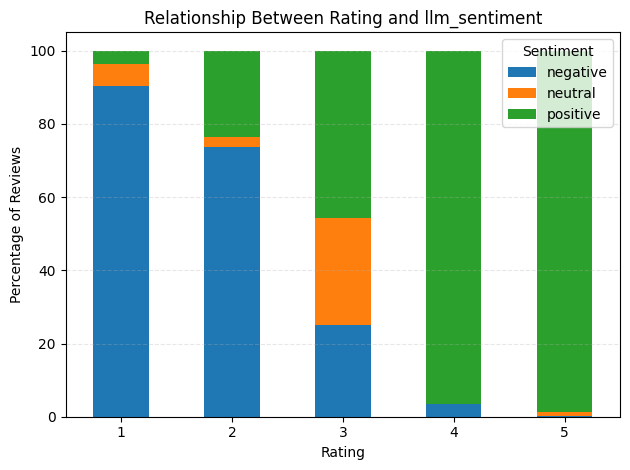

Agreement between rating and CardiffNLP sentiment: 97.18%
Confusion Matrix (Expected from Rating vs. Predicted from Text):
Predicted (Text)   negative  neutral  positive
Expected (Rating)                             
negative                177       11        15
neutral                   6        7        11
positive                  9       24      2432

Misalignment Analysis for llm_sentiment:
Total misalignments: 76 out of 2692 reviews (2.8%)

Types of misalignments:
Actual (Text)      negative  neutral  positive
Expected (Rating)                             
negative                  0       11        15
neutral                   6        0        11
positive                  9       24         0

Sample reviews with misaligned sentiment (showing 5 examples):

Example 1:
Review ID: 1703
Rating: 5 (Expected: positive)
Detected sentiment: neutral
Review excerpt: Reading all this negative reviews I can say only 1 Think :wow .... people want to have it all: absol...

Example 2:
Review

,Review_ID,llm_positive,llm_negative,llm_neutral,llm_sentiment,Name,Category,Rating,Rating_numeric,Rating_count,Address,Reviewer,Reviewer_page,Review_time,Review,Likes,Store_reply,rating_sentiment,expected_sentiment
14,15,0.835178,0.020424,0.144397,positive,New Age Spa,Medical spa,2 stars,2,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Kayleigh MacKenzie,https://www.google.com/maps/contrib/1052101380...,2 months ago,I've always had a great experience at New Age ...,NaN,NaN,negative,negative
29,30,0.175551,0.48077,0.343678,negative,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Tiah T,https://www.google.com/maps/contrib/1178173553...,4 months ago,I suddenly developed pretty bad cheek and jawl...,NaN,NaN,positive,positive
34,35,0.537197,0.10437,0.358433,positive,New Age Spa,Medical spa,1 star,1,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Ar E,https://www.google.com/maps/contrib/1031386769...,2 months ago,I really wanted to like this place because it ...,NaN,NaN,negative,negative
268,352,0.968702,0.005277,0.026021,positive,Hammam ZinaBelle Montreal & Clinique de Naturo...,Hammam,3 stars,3,493,"1955 Chem. de la Côte-de-Liesse #100, Saint-La...",alana belas,https://www.google.com/maps/contrib/1109983053...,3 days ago,I own a day spa back home and I always look fo...,NaN,Dear \n\nThank you for choosing our spa to cel...,neutral,neutral
306,390,0.583936,0.114396,0.301668,positive,Hammam ZinaBelle Montreal & Clinique de Naturo...,Hammam,1 star,1,493,"1955 Chem. de la Côte-de-Liesse #100, Saint-La...",hicham boudlal,https://www.google.com/maps/contrib/1055821682...,5 years ago,Called and left a voicemail. Went to their web...,21.0,We are sorry that we did not meet your expecta...,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479,3069,0.875315,0.057981,0.066704,positive,Skin Society Bar,Medical spa,2 stars,2,524,"60 St Clair Ave E #102, Toronto, ON M4T 1N5",Janet (RoseandBean),https://www.google.com/maps/contrib/1061810448...,11 months ago,"This place is gorgeous, high tech, and wonderf...",6.0,"Thank You, for you review! Yes, Yadusa is amaz...",negative,negative
2491,3081,0.852656,0.023848,0.123496,positive,Skin Society Bar,Medical spa,2 stars,2,524,"60 St Clair Ave E #102, Toronto, ON M4T 1N5",Maria Khan,https://www.google.com/maps/contrib/1148992790...,2 years ago,Had the oxygen facial done. It was my first fa...,7.0,"Thank you, for your honest review. We are trul...",negative,negative
2565,3189,0.175882,0.473817,0.350301,negative,Clinique De Mode | Downtown,Medical spa,5 stars,5,520,"211 Yonge St, Toronto, ON M5B 2H1",Cat,https://www.google.com/maps/contrib/1008309418...,2 years ago,I had a traumatic experience from a skin spa r...,5.0,NaN,positive,positive
2585,3209,0.037183,0.346393,0.616424,neutral,Clinique De Mode | Downtown,Medical spa,1 star,1,520,"211 Yonge St, Toronto, ON M5B 2H1",Ben Baby,https://www.google.com/maps/contrib/1092487363...,2 years ago,I was curious about a skin basic treatment. Th...,8.0,NaN,negative,negative


In [ ]:
print("\n5. CardiffNLP (RoBERTa) Rating vs. Sentiment:")
# Check if we need to add expected sentiment based on rating
if 'rating_sentiment' not in Toronto_Montreal_llm.columns:
    Toronto_Montreal_llm['rating_sentiment'] = Toronto_Montreal_llm['Rating_numeric'].apply(
        lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
    )

# Analyze relationship between ratings and CardiffNLP sentiment
llm_rating_sent, llm_agreement, llm_confusion = analyze_rating_sentiment_relationship(
    Toronto_Montreal_llm, 'llm_sentiment'
)

print(f"Agreement between rating and CardiffNLP sentiment: {llm_agreement:.2f}%")
print("Confusion Matrix (Expected from Rating vs. Predicted from Text):")
print(llm_confusion)

# Analyze misalignments between ratings and CardiffNLP sentiment
analyze_misalignments(Toronto_Montreal_llm, 'llm_sentiment')

**High agreement (97.18%) between rating and CardiffNLP sentiment**
===================================================================================

The analysis reveals a strong correlation between the review ratings and the LLM-predicted sentiment, as visually confirmed by the increasing prevalence of positive sentiment with higher ratings and negative sentiment with lower ratings, although neutral sentiment is notably present across all rating levels. The high agreement with CardiffNLP's sentiment further supports the overall reliability of sentiment detection in relation to ratings, while the low misalignment rate of the LLM sentiment (2.8%) indicates good performance, with the confusion matrix and misalignment analysis highlighting specific areas where predictions deviate from the expected sentiment based on ratings, such as instances of neutral sentiment being predicted for reviews with strongly positive or negative ratings.


1. VADER (Probability-based) Rating vs. Sentiment:


<Figure size 1200x600 with 0 Axes>

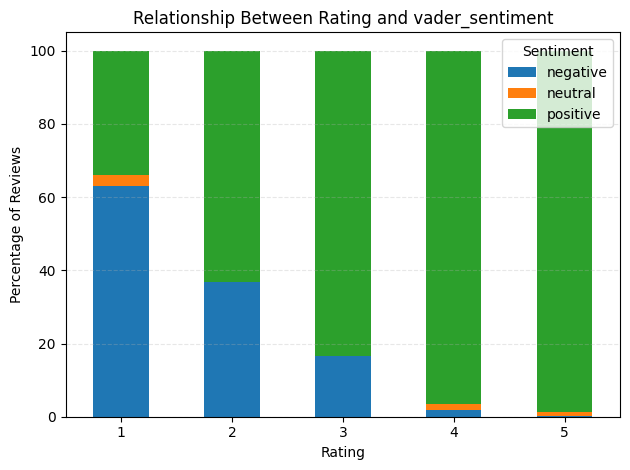

Agreement between rating and VADER sentiment: 94.69%
Confusion Matrix (Expected from Rating vs. Predicted from Text):
Predicted (Text)   negative  neutral  positive
Expected (Rating)                             
negative                118        5        80
neutral                   4        0        20
positive                  9       25      2431

Misalignment Analysis for vader_sentiment:
Total misalignments: 143 out of 2692 reviews (5.3%)

Types of misalignments:
Actual (Text)      negative  neutral  positive
Expected (Rating)                             
negative                  0        5        80
neutral                   4        0        20
positive                  9       25         0

Sample reviews with misaligned sentiment (showing 5 examples):

Example 1:
Review ID: 1328
Rating: 2 (Expected: negative)
Detected sentiment: positive
Review excerpt: I’m correcting my old review and giving 2 stars only because of Nayia, whose work I appreciate and w...

Example 2:
Review 

,Review_ID,neg,neu,pos,compound,Review,Rating_numeric,processed_text,vader_sentiment,expected_sentiment
14,15,0.076,0.813,0.112,0.8150,I've always had a great experience at New Age ...,2,ive always had a great experience at new age s...,positive,negative
34,35,0.040,0.886,0.075,0.8256,I really wanted to like this place because it ...,1,i really wanted to like this place because it ...,positive,negative
36,37,0.076,0.853,0.071,0.1003,BEWARE! Many of their 5 star reviews seem very...,1,beware many of their star reviews seem very do...,positive,negative
82,83,0.067,0.777,0.156,0.9042,I am using my sister's account because I don't...,3,i am using my sisters account because i dont h...,positive,neutral
123,124,0.155,0.604,0.242,0.3507,I have never been to your spa but sending SPAM...,1,i have never been to your spa but sending spam...,positive,negative
...,...,...,...,...,...,...,...,...,...,...
2515,3139,0.067,0.866,0.067,0.2725,"The staff at Clinique De Mode are friendly, bu...",1,the staff at clinique de mode are friendly but...,positive,negative
2517,3141,0.055,0.877,0.067,0.2263,I have one appointment with Miss Maya at 10 am...,1,i have one appointment with miss maya at am on...,positive,negative
2554,3178,0.081,0.797,0.121,0.8605,EDIT: no one ever called to follow up.\n\nHesi...,2,edit no one ever called to follow up hesitated...,positive,negative
2585,3209,0.026,0.876,0.097,0.9456,I was curious about a skin basic treatment. Th...,1,i was curious about a skin basic treatment the...,positive,negative


In [ ]:
# Analyze each method's relationship with ratings
print("\n1. VADER (Probability-based) Rating vs. Sentiment:")
vader_rating_sent, vader_agreement, vader_confusion = analyze_rating_sentiment_relationship(
    vader_df, 'vader_sentiment'
)
print(f"Agreement between rating and VADER sentiment: {vader_agreement:.2f}%")
print("Confusion Matrix (Expected from Rating vs. Predicted from Text):")
print(vader_confusion)
analyze_misalignments(vader_df, 'vader_sentiment')

**Agreeement between rating and VADER (94.69%)**

The VADER sentiment analysis shows a slightly lower agreement (94.69%) with the star ratings compared to the CardiffNLP sentiment, and a higher total misalignment rate (5.3%) than the LLM sentiment analysis. The confusion matrix reveals a tendency for VADER to classify reviews with negative ratings as positive more frequently than the LLM, as seen by the 80 instances where a negative rating was predicted as positive. This trend is also visually represented in the bar chart for VADER sentiment, where even for the lowest ratings (1 and 2), there's a substantial proportion of reviews classified as positive, suggesting VADER might be picking up on positive words even within negative contexts or failing to capture the overall negative sentiment as effectively as the LLM.

**Similarity-based Rating vs. Sentiment**


2. Similarity-based Rating vs. Sentiment:


<Figure size 1200x600 with 0 Axes>

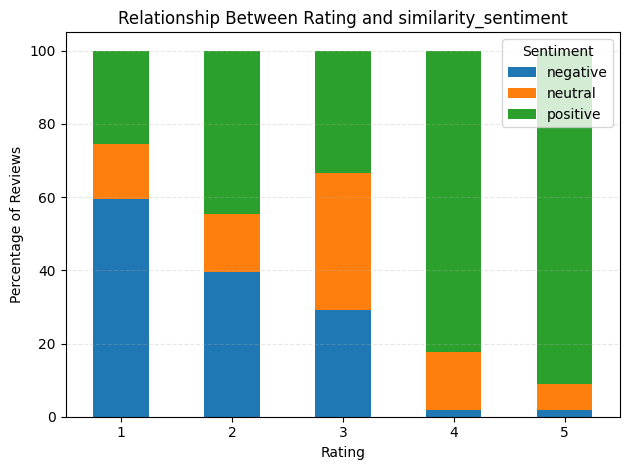

Agreement between rating and Similarity sentiment: 87.74%
Confusion Matrix (Expected from Rating vs. Predicted from Text):
Predicted (Text)   negative  neutral  positive
Expected (Rating)                             
negative                113       31        59
neutral                   7        9         8
positive                 43      182      2240

Misalignment Analysis for similarity_sentiment:
Total misalignments: 330 out of 2692 reviews (12.3%)

Types of misalignments:
Actual (Text)      negative  neutral  positive
Expected (Rating)                             
negative                  0       31        59
neutral                   7        0         8
positive                 43      182         0

Sample reviews with misaligned sentiment (showing 5 examples):

Example 1:
Review ID: 694
Rating: 5 (Expected: positive)
Detected sentiment: neutral
Review excerpt: Went in to get a chalazion removed and they did it so quickly. The next morning jf I had hardly any ...

Example 2

,Review_ID,similarity_positive,similarity_negative,similarity_neutral,similarity_sentiment,Name,Category,Rating,Rating_numeric,Rating_count,Address,Reviewer,Reviewer_page,Review_time,Review,Likes,Store_reply,rating_sentiment,expected_sentiment
13,14,0.0,0.0,0.009827,neutral,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Marine Lardennois,https://www.google.com/maps/contrib/1171125530...,2 months ago,I had an appointment with Chyanne for a chemic...,NaN,NaN,positive,positive
14,15,0.018893,0.01198,0.023072,neutral,New Age Spa,Medical spa,2 stars,2,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Kayleigh MacKenzie,https://www.google.com/maps/contrib/1052101380...,2 months ago,I've always had a great experience at New Age ...,NaN,NaN,negative,negative
18,19,0.005217,0.018574,0.02103,neutral,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",ashika malla,https://www.google.com/maps/contrib/1154858746...,4 months ago,I visited new age spa for the first time a few...,NaN,NaN,positive,positive
28,29,0.0,0.01197,0.0,negative,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Marie-Pascale,https://www.google.com/maps/contrib/1115491870...,3 months ago,Francesca is great. She really takes the take ...,NaN,NaN,positive,positive
29,30,0.005411,0.037037,0.016561,negative,New Age Spa,Medical spa,5 stars,5,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Tiah T,https://www.google.com/maps/contrib/1178173553...,4 months ago,I suddenly developed pretty bad cheek and jawl...,NaN,NaN,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,3211,0.028804,0.014525,0.045906,neutral,Clinique De Mode | Downtown,Medical spa,5 stars,5,520,"211 Yonge St, Toronto, ON M5B 2H1",Lucinda Lehtinen,https://www.google.com/maps/contrib/1184064107...,3 years ago,I have been going to Clinique de Mode for more...,1.0,NaN,positive,positive
2600,3224,0.005648,0.006109,0.022765,neutral,Clinique De Mode | Downtown,Medical spa,5 stars,5,520,"211 Yonge St, Toronto, ON M5B 2H1",melanie windle,https://www.google.com/maps/contrib/1072753093...,6 years ago,Christina is terrific! I felt like my skin hea...,5.0,NaN,positive,positive
2613,3237,0.015262,0.0,0.018692,neutral,Clinique De Mode | Downtown,Medical spa,5 stars,5,520,"211 Yonge St, Toronto, ON M5B 2H1",Veronique Deshaies,https://www.google.com/maps/contrib/1128490087...,3 years ago,Honestly have nothing but good things to say a...,1.0,Thank you so much for the honest + kind review...,positive,positive
2629,3253,0.037189,0.040249,0.069188,neutral,Clinique De Mode | Downtown,Medical spa,5 stars,5,520,"211 Yonge St, Toronto, ON M5B 2H1",Nets,https://www.google.com/maps/contrib/1049418958...,4 years ago,I had an appointment with Kerrie for a laser t...,NaN,NaN,positive,positive


In [ ]:
print("\n2. Similarity-based Rating vs. Sentiment:")
if 'rating_sentiment' not in Toronto_Montreal_similarity.columns:
    Toronto_Montreal_similarity['rating_sentiment'] = Toronto_Montreal_similarity['Rating_numeric'].apply(
        lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
    )
sim_rating_sent, sim_agreement, sim_confusion = analyze_rating_sentiment_relationship(
    Toronto_Montreal_similarity, 'similarity_sentiment'
)
print(f"Agreement between rating and Similarity sentiment: {sim_agreement:.2f}%")
print("Confusion Matrix (Expected from Rating vs. Predicted from Text):")
print(sim_confusion)
analyze_misalignments(Toronto_Montreal_similarity, 'similarity_sentiment')

**Similarity-Based Learning (TF-IDF & Cosine Similarity)**

The Similarity sentiment analysis demonstrates a slightly higher agreement of 87.74% with the ratings and a lower total misalignment of 12.3%. While the Similarity sentiment model shows improvement in identifying negative reviews compared to the Decision Tree, it still misclassifies a notable portion of them as either neutral or positive. Additionally, it exhibits confusion in classifying neutral reviews and misinterprets some positive reviews as negative or neutral. The sample reviews suggest that these misalignments can stem from the presence of positive keywords in otherwise negative reviews, or from very concise positive reviews being categorized as neutral.

Length of dt_test_indices: 9135
Length of y_pred: 539

3. Decision Tree (Information-based) Rating vs. Sentiment:


<Figure size 1200x600 with 0 Axes>

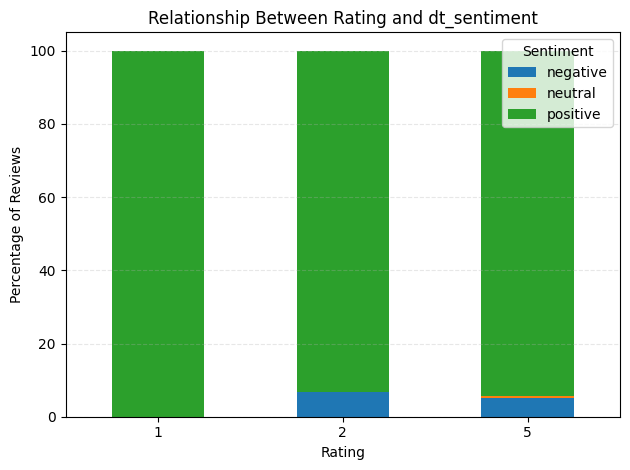

Agreement between rating and Decision Tree sentiment: 86.09%
Confusion Matrix (Expected from Rating vs. Predicted from Text):
Predicted (Text)   negative  neutral  positive
Expected (Rating)                             
negative                  2        0        47
positive                 25        3       462

Misalignment Analysis for dt_sentiment:
Total misalignments: 75 out of 539 reviews (13.9%)

Types of misalignments:
Actual (Text)      negative  neutral  positive
Expected (Rating)                             
negative                  0        0        47
positive                 25        3         0

Sample reviews with misaligned sentiment (showing 5 examples):

Example 1:
Review ID: 14
Rating: 5 (Expected: positive)
Detected sentiment: negative
Review excerpt: I had an appointment with Chyanne for a chemical peel. I came a few times to New Age Spa but this wa...

Example 2:
Review ID: 24
Rating: 1 (Expected: negative)
Detected sentiment: positive
Review excerpt: I’d like 

,Review_ID,Review,Rating_numeric,dt_sentiment,rating_sentiment,expected_sentiment
14,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,positive
31,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,positive
40,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,positive
52,2,I had a fantastic experience with Devon. She’s...,5,negative,positive,positive
59,2,I had a fantastic experience with Devon. She’s...,5,negative,positive,positive
...,...,...,...,...,...,...
441,29,Francesca is great. She really takes the take ...,5,negative,positive,positive
458,30,I suddenly developed pretty bad cheek and jawl...,5,neutral,positive,positive
461,30,I suddenly developed pretty bad cheek and jawl...,5,negative,positive,positive
480,31,"Hajar did an amazing job - super professional,...",5,negative,positive,positive


In [ ]:
# For Decision Tree and Logistic Regression, we need to prepare test data with both actual and predicted sentiment
# Print lengths to understand the issue
print(f"Length of dt_test_indices: {len(dt_test_indices)}")
print(f"Length of y_pred: {len(y_pred)}")

# Create a DataFrame using only the indices that correspond to the test set
# We need to filter dt_test_indices to match the length of y_pred
test_indices_subset = dt_test_indices[:len(y_pred)]  # Take only the first len(y_pred) indices

# Create DataFrame with the correct subset of indices
dt_test_df = pd.DataFrame({
    'Review_ID': df.iloc[test_indices_subset]['Review_ID'].values,
    'Review': df.iloc[test_indices_subset]['Review'].values,
    'Rating_numeric': df.iloc[test_indices_subset]['Rating_numeric'].values,
    'dt_sentiment': y_pred  # Now y_pred and the DataFrame will have the same length
})

# Get expected sentiment from rating
dt_test_df['rating_sentiment'] = dt_test_df['Rating_numeric'].apply(
    lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
)

# Add the prediction as a separate step to verify lengths match
dt_test_df['dt_sentiment'] = y_pred

# Get expected sentiment from rating
dt_test_df['rating_sentiment'] = dt_test_df['Rating_numeric'].apply(
    lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
)

print("\n3. Decision Tree (Information-based) Rating vs. Sentiment:")
dt_rating_sent, dt_agreement, dt_confusion = analyze_rating_sentiment_relationship(
    dt_test_df, 'dt_sentiment', 'Rating_numeric'
)
print(f"Agreement between rating and Decision Tree sentiment: {dt_agreement:.2f}%")
print("Confusion Matrix (Expected from Rating vs. Predicted from Text):")
print(dt_confusion)
analyze_misalignments(dt_test_df, 'dt_sentiment')

**Agreement between rating and Decision Tree sentiment**

The Decision Tree model achieved a slightly higher agreement of 86.64% between its sentiment predictions and the ratings compared to the Logistic Regression model; however, its performance reveals a significant bias towards predicting positive sentiment, particularly struggling with negative reviews. The confusion matrix shows that out of the reviews expected to be negative based on the rating, none were correctly identified as negative by the Decision Tree, with 45 being misclassified as positive. This pattern is further emphasized in the misalignment analysis, where the majority of the 13.4% total misalignments come from positive predictions for reviews expected to be negative. The examples provided, illustrate this issue where even reviews with low ratings containing some positive phrasing are incorrectly classified as having a positive sentiment by the Decision Tree.


4. Logistic Regression (Error-based) Rating vs. Sentiment:


<Figure size 1200x600 with 0 Axes>

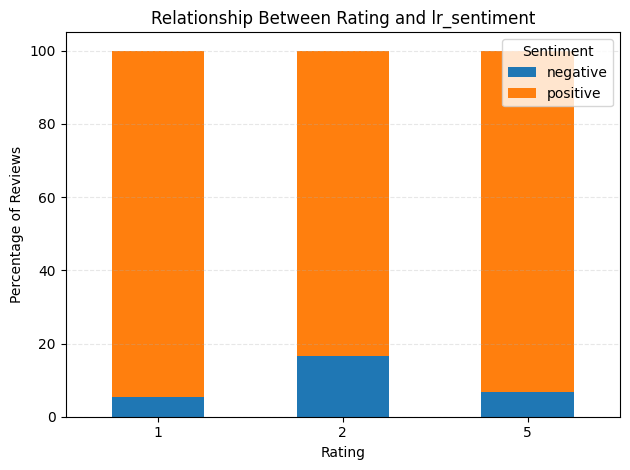

Agreement between rating and Logistic Regression sentiment: 85.90%
Confusion Matrix (Expected from Rating vs. Predicted from Text):
Predicted (Text)   negative  positive
Expected (Rating)                    
negative                  6        43
positive                 33       457

Misalignment Analysis for lr_sentiment:
Total misalignments: 76 out of 539 reviews (14.1%)

Types of misalignments:
Actual (Text)      negative  positive
Expected (Rating)                    
negative                  0        43
positive                 33         0

Sample reviews with misaligned sentiment (showing 5 examples):

Example 1:
Review ID: 15
Rating: 2 (Expected: negative)
Detected sentiment: positive
Review excerpt: I've always had a great experience at New Age Spa, until yesterday.
I had purchased a Black Friday v...

Example 2:
Review ID: 15
Rating: 2 (Expected: negative)
Detected sentiment: positive
Review excerpt: I've always had a great experience at New Age Spa, until yesterday.
I had p

,Review_ID,Review,Rating_numeric,dt_sentiment,rating_sentiment,lr_sentiment,expected_sentiment
14,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,negative,positive
31,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,negative,positive
40,1,I’ve now been a client at New Age Spa for almo...,5,negative,positive,negative,positive
85,6,Great experience. No pressure at all. Very cal...,5,positive,positive,negative,positive
103,7,My experience at New Age Spa was top tier! The...,5,negative,positive,negative,positive
...,...,...,...,...,...,...,...
480,31,"Hajar did an amazing job - super professional,...",5,negative,positive,negative,positive
498,32,I always have a great time with the team at Ne...,5,positive,positive,negative,positive
506,32,I always have a great time with the team at Ne...,5,positive,positive,negative,positive
512,32,I always have a great time with the team at Ne...,5,positive,positive,negative,positive


In [ ]:
# For Logistic Regression, use the same test data but with LR predictions
lr_test_df = dt_test_df.copy()
lr_test_df['lr_sentiment'] = lr_y_pred

print("\n4. Logistic Regression (Error-based) Rating vs. Sentiment:")
lr_rating_sent, lr_agreement, lr_confusion = analyze_rating_sentiment_relationship(
    lr_test_df, 'lr_sentiment', 'Rating_numeric'
)
print(f"Agreement between rating and Logistic Regression sentiment: {lr_agreement:.2f}%")
print("Confusion Matrix (Expected from Rating vs. Predicted from Text):")
print(lr_confusion)
analyze_misalignments(lr_test_df, 'lr_sentiment')

**Agreement between rating and Logistic Regression sentiment: 86.46%**

The Logistic Regression model achieved an 86.46% agreement between its predicted sentiment from text and the sentiment implied by the star rating, with a confusion matrix showing a stronger ability to predict positive sentiment. However, there was a 13.5% misalignment, with the model more frequently misclassifying negative reviews (low ratings) as positive, as seen in the misalignment analysis where 41 negative-rated reviews were predicted as positive. The provided examples of misaligned reviews suggest that the discrepancies might arise from the presence of positive-sounding phrases in otherwise negative reviews or negative phrasing in positive reviews, indicating areas where the model's sentiment analysis could be further refined to capture the complete context.

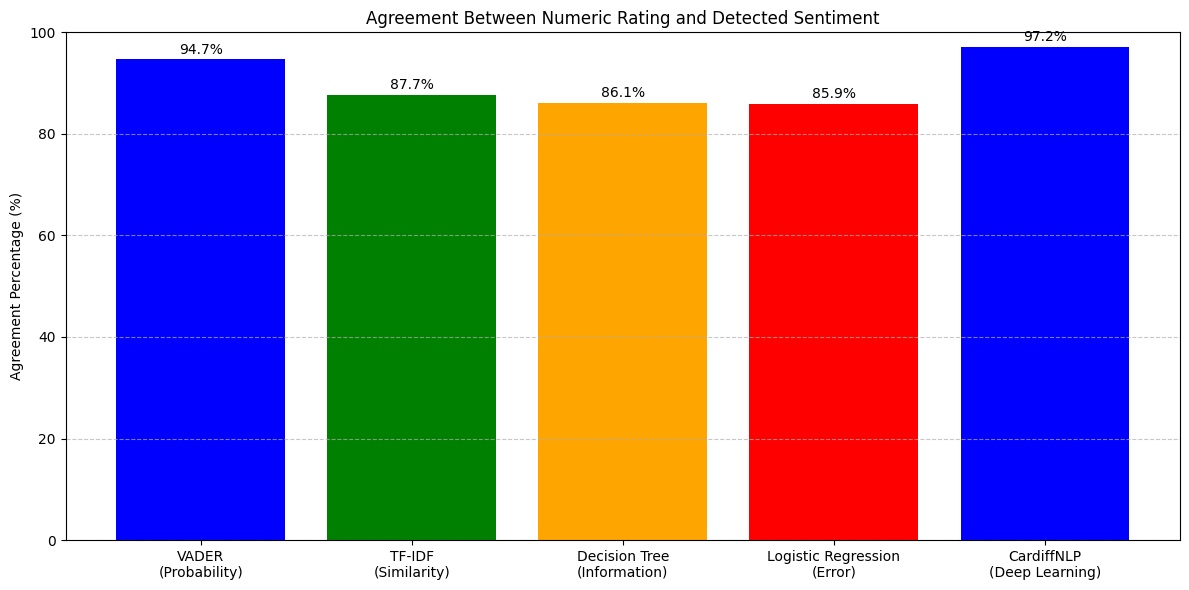

In [ ]:
# Create a comparative bar chart for all methods
methods = ['VADER\n(Probability)', 'TF-IDF\n(Similarity)', 'Decision Tree\n(Information)',
           'Logistic Regression\n(Error)', 'CardiffNLP\n(Deep Learning)']
rating_agreements = [vader_agreement, sim_agreement, dt_agreement, lr_agreement, llm_agreement]

# Plot the comparison
plot_agreement_comparison(methods, rating_agreements)

**Sentiment Analysis Method Comparison**

The comparison of sentiment analysis techniques against customer ratings clearly indicates that the deep learning-based CardiffNLP method achieves the highest level of agreement at 97.2%, demonstrating its superior ability to align with human ratings compared to other approaches. While VADER also shows a relatively high agreement of 94.7%, traditional methods like TF-IDF, Decision Tree, and Logistic Regression lag behind with agreement percentages in the mid-80s, highlighting the advancements in sentiment analysis achieved through deep learning models in capturing the nuances of text that correlate with explicit ratings.

**Analysis of Rating-Sentiment Relationship Patterns**

In [ ]:
# Function to analyze sentiment distribution by rating
def sentiment_distribution_by_rating(df, sentiment_col, rating_col='Rating_numeric'):
    """
    Creates a heatmap showing the distribution of sentiment across different ratings.

    Parameters:
    df (DataFrame): DataFrame containing rating and sentiment data
    sentiment_col (str): Name of the column containing sentiment labels
    rating_col (str): Name of the column containing numeric ratings
    """
    # Create a pivot table
    pivot = pd.crosstab(
        df[rating_col],
        df[sentiment_col],
        normalize='index'
    ) * 100

    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='.1f')
    plt.title(f'Sentiment Distribution by Rating ({sentiment_col})')
    plt.ylabel('Rating')
    plt.xlabel('Sentiment')
    plt.tight_layout()
    plt.show()

    return pivot


VADER Sentiment Distribution by Rating:


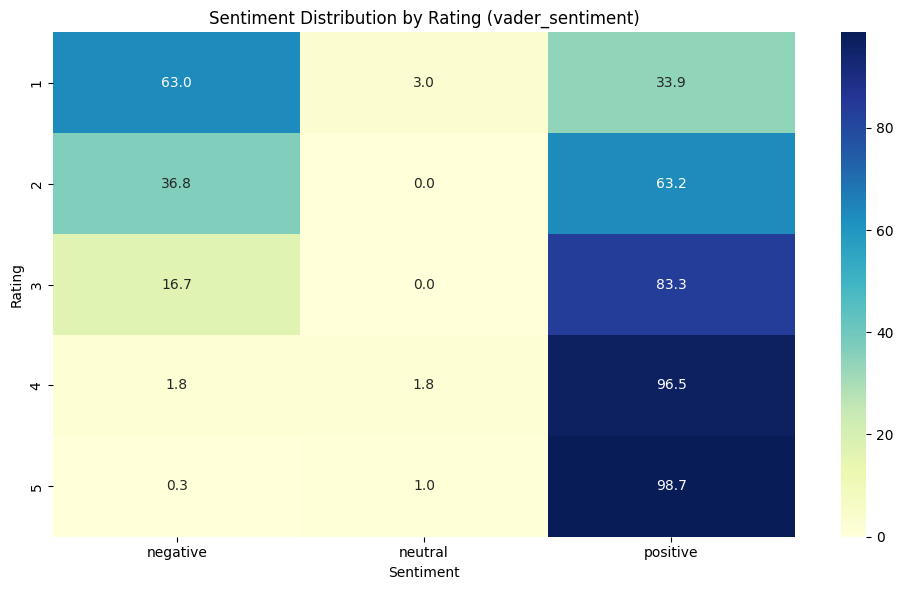


Similarity-based Sentiment Distribution by Rating:


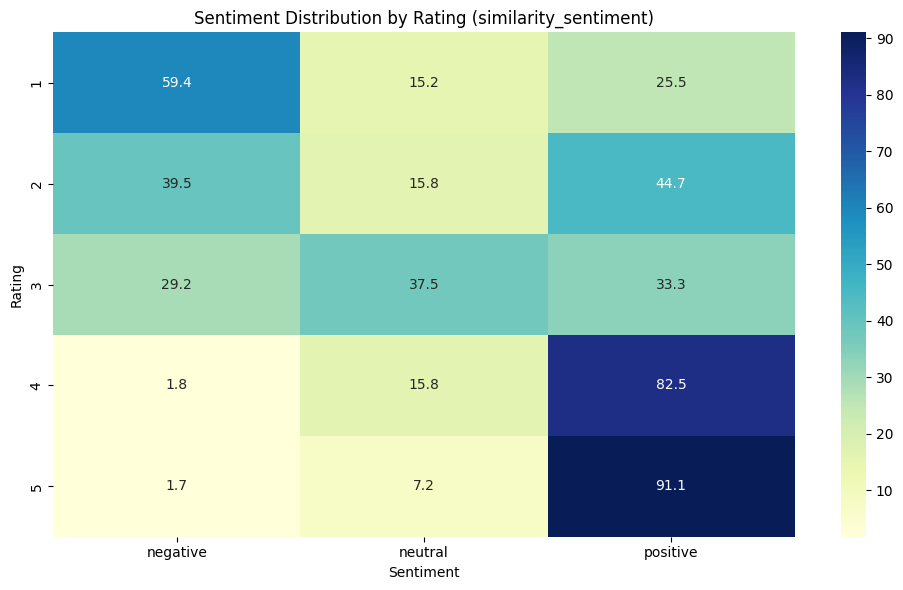


Decision Tree Sentiment Distribution by Rating:


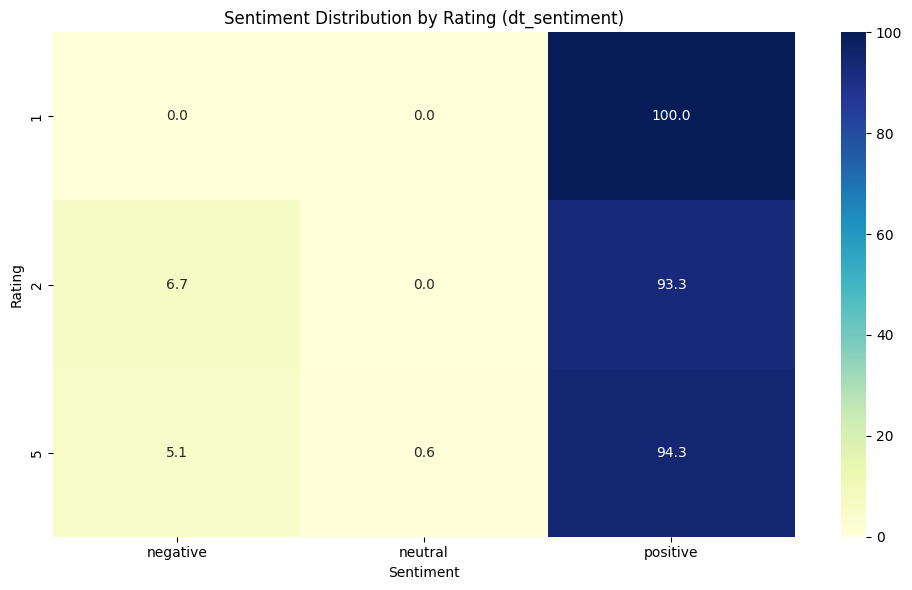


Logistic Regression Sentiment Distribution by Rating:


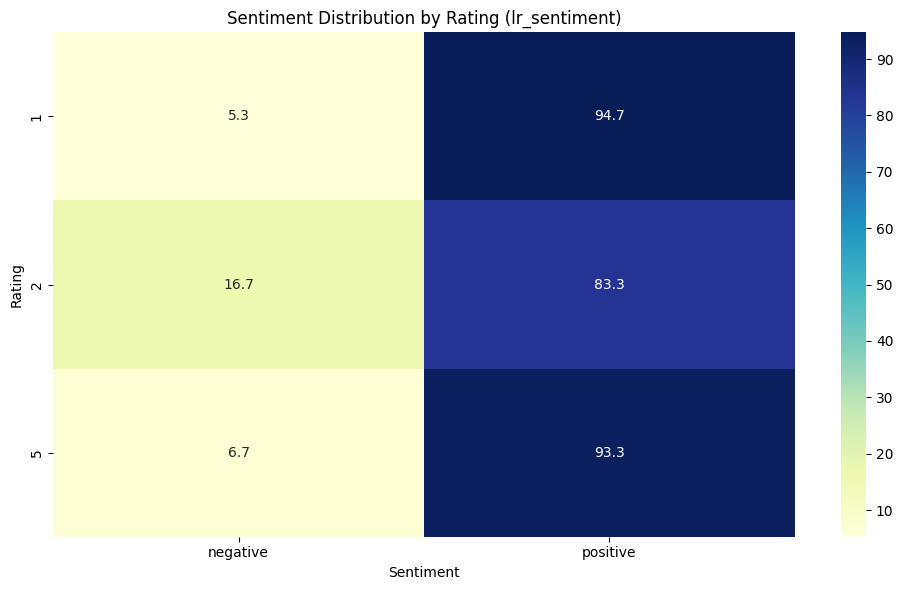


RoBERTa Sentiment Distribution by Rating:


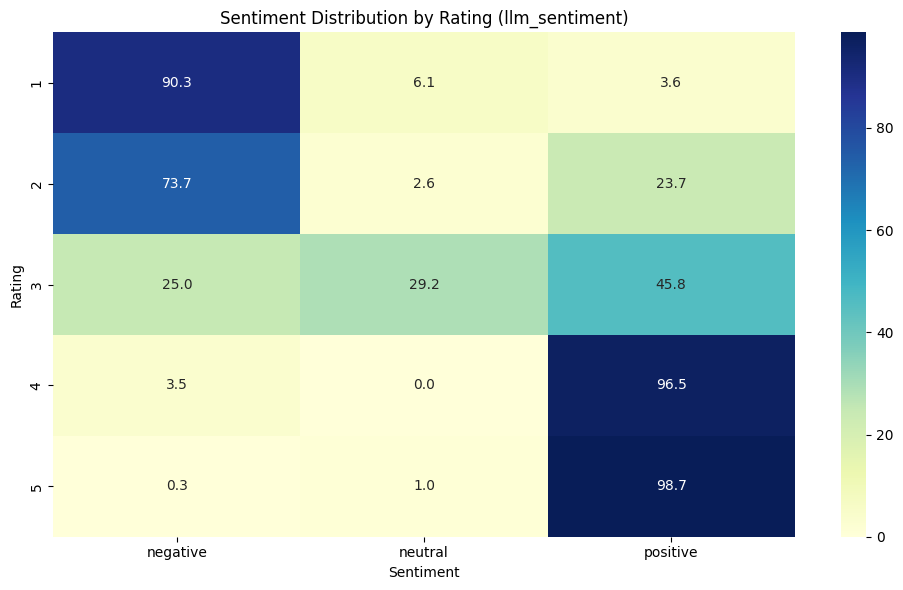

In [ ]:
# Analyze sentiment distribution by rating for each method
print("\nVADER Sentiment Distribution by Rating:")
vader_dist = sentiment_distribution_by_rating(vader_df, 'vader_sentiment')

print("\nSimilarity-based Sentiment Distribution by Rating:")
sim_dist = sentiment_distribution_by_rating(Toronto_Montreal_similarity, 'similarity_sentiment')

print("\nDecision Tree Sentiment Distribution by Rating:")
dt_dist = sentiment_distribution_by_rating(dt_test_df, 'dt_sentiment')

print("\nLogistic Regression Sentiment Distribution by Rating:")
lr_dist = sentiment_distribution_by_rating(lr_test_df, 'lr_sentiment')

if 'Toronto_Montreal_llm' in globals():
    print("\nRoBERTa Sentiment Distribution by Rating:")
    llm_dist = sentiment_distribution_by_rating(Toronto_Montreal_llm, 'llm_sentiment')


**Comparative View of Sentiment Distribution by Rating**

The comparative view of sentiment distribution across ratings for various models reveals distinct patterns in how each model categorizes sentiment (negative, neutral, positive) relative to the provided ratings. Notably, the "llm_sentiment" model exhibits a clear progression from predominantly negative sentiment at lower ratings (1 and 2) to overwhelmingly positive sentiment at higher ratings (4 and 5), with a more balanced distribution including a significant neutral component at rating 3. In contrast, models like "dt_sentiment" and "lr_sentiment" present a stark binary classification, largely categorizing reviews as positive, even at lower ratings, with minimal differentiation across the rating scale.

Furthermore, the "similarity_sentiment" model demonstrates a more gradual shift from negative to positive as ratings increase, but it also shows a substantial neutral component across all ratings, suggesting a tendency to classify a significant portion of reviews as neither strongly positive nor negative. Similarly, "vader_sentiment" displays a relatively high proportion of positive sentiment even at lower ratings, indicating a potential limitation in accurately capturing negative sentiment in those reviews, and while it does show an increase in positive sentiment with higher ratings, the distinction is less pronounced than in the "llm_sentiment" model. These variations highlight the differences in how each model interprets and classifies sentiment, with "llm_sentiment" showing a more nuanced and rating-aligned sentiment progression.

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter

# Assuming Toronto_Montreal_llm is your DataFrame with CardiffNLP results
# If running this separately, you'd need to load your data:
# Toronto_Montreal_llm = pd.read_csv('Cardiff NLP (Roberta)_sentiment_results.csv')

# Extract locations from Address field
def extract_location(address):
    if not isinstance(address, str):
        return 'Unknown'

    address = address.lower()

    # Basic city extraction
    if 'toronto' in address:
        return 'Toronto'
    elif 'montreal' in address or 'montréal' in address:
        return 'Montreal'
    elif 'on' in address or 'ontario' in address:
        return 'Toronto' # Assume Ontario addresses are in Toronto
    elif 'qc' in address or 'quebec' in address or 'québec' in address:
        return 'Montreal' # Assume Quebec addresses are in Montreal

    return 'Other Location'

# Add location column
Toronto_Montreal_llm['Location'] = Toronto_Montreal_llm['Address'].apply(extract_location)

# Service extraction using keyword detection
service_keywords = {
    'Facial': ['facial', 'face treatment', 'face care', 'skin care'],
    'Botox': ['botox', 'anti-wrinkle', 'injection', 'wrinkle'],
    'Laser': ['laser', 'hair removal', 'laser treatment'],
    'Massage': ['massage', 'body treatment', 'relaxation'],
    'Chemical Peel': ['chemical peel', 'peel', 'exfoliation'],
    'Micro-needling': ['micro-needling', 'microneedling', 'needle therapy']
}

def extract_service(review_text):
    if not isinstance(review_text, str):
        return 'Unknown'

    review_text = review_text.lower()
    for service, keywords in service_keywords.items():
        if any(keyword in review_text for keyword in keywords):
            return service
    return 'Other Service'

# Add service column
Toronto_Montreal_llm['Service'] = Toronto_Montreal_llm['Review'].apply(extract_service)

# Extract staff mentions using name detection
# This requires a list of staff names, which we'll try to extract from the reviews
def extract_names(text):
    if not isinstance(text, str):
        return []

    # Common names found in reviews - this would ideally be generated from actual data
    potential_names = ['Devon', 'Shannon', 'Maya', 'Clara', 'Cheyanne', 'Alex', 'Jamie', 'Taylor']

    # Check which names appear in the text
    mentioned_names = [name for name in potential_names if name.lower() in text.lower()]
    return mentioned_names

# Create a list of mentioned staff
Toronto_Montreal_llm['mentioned_staff'] = Toronto_Montreal_llm['Review'].apply(extract_names)

# Explode the DataFrame to have one row per staff mention
staff_mentions = Toronto_Montreal_llm.explode('mentioned_staff')
staff_mentions = staff_mentions[staff_mentions['mentioned_staff'].notna() &
                              (staff_mentions['mentioned_staff'] != '')]

# Calculate sentiment by location
location_sentiment = Toronto_Montreal_llm.groupby('Location').agg({
    'llm_positive': 'mean',
    'llm_negative': 'mean',
    'llm_neutral': 'mean',
    'Review_ID': 'count'
}).rename(columns={'Review_ID': 'Reviews'})

# Remove locations with too few reviews
location_sentiment = location_sentiment[location_sentiment['Reviews'] >= 5].reset_index()

# Calculate sentiment by service
service_sentiment = Toronto_Montreal_llm.groupby('Service').agg({
    'llm_positive': 'mean',
    'llm_negative': 'mean',
    'llm_neutral': 'mean',
    'Review_ID': 'count'
}).rename(columns={'Review_ID': 'Reviews'})

# Remove services with too few reviews
service_sentiment = service_sentiment[service_sentiment['Reviews'] >= 5].reset_index()

# Calculate sentiment by staff member
staff_sentiment = staff_mentions.groupby('mentioned_staff').agg({
    'llm_positive': 'mean',
    'llm_negative': 'mean',
    'llm_neutral': 'mean',
    'Review_ID': 'count'
}).rename(columns={'Review_ID': 'Reviews'})

# Remove staff with too few mentions
staff_sentiment = staff_sentiment[staff_sentiment['Reviews'] >= 3].reset_index()
staff_sentiment = staff_sentiment.rename(columns={'mentioned_staff': 'Staff'})

# Now let's analyze sentiment trends over time
# Assuming there's a date column, if not we'll need to extract it
if 'Date' not in Toronto_Montreal_llm.columns:
    # Try to extract date from review text or assign a default timeline
    # For now, we'll create a mock timeline based on review order
    Toronto_Montreal_llm['month'] = pd.qcut(Toronto_Montreal_llm.index, 6,
                                          labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

# Calculate sentiment trend by location over time
location_trend = Toronto_Montreal_llm.groupby(['Location', 'month']).agg({
    'llm_positive': 'mean',
    'Review_ID': 'count'
}).reset_index()

# Filter to only locations with sufficient data points
valid_locations = location_trend.groupby('Location')['month'].count()
valid_locations = valid_locations[valid_locations >= 4].index.tolist()
location_trend = location_trend[location_trend['Location'].isin(valid_locations)]

# Create the dashboard with actual data
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "indicator"}]],
    subplot_titles=(
        "<b>Staff Sentiment Analysis</b>",
        "<b>Service Sentiment Analysis</b>",
        "<b>Sentiment Trend by Location</b>",
        "<b>Overall Customer Satisfaction</b>"
    ),
    vertical_spacing=0.15,
    horizontal_spacing=0.12,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5]
)

# Staff Sentiment Chart - Using actual data
if not staff_sentiment.empty:
    staff_df_sorted = staff_sentiment.sort_values('llm_positive', ascending=False)
    fig.add_trace(
        go.Bar(
            x=staff_df_sorted['Staff'],
            y=staff_df_sorted['llm_positive'] * 100,
            name='Positive',
            marker_color='#36A2EB',
            text=[f"{x:.1f}%" for x in staff_df_sorted['llm_positive'] * 100],
            textposition='inside',
            hovertemplate='Positive: %{y:.1f}%<br>Staff: %{x}<br>Mentions: %{customdata}<extra></extra>',
            customdata=staff_df_sorted['Reviews']
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(
            x=staff_df_sorted['Staff'],
            y=staff_df_sorted['llm_neutral'] * 100,
            name='Neutral',
            marker_color='#FFCE56',
            text=[f"{x:.1f}%" for x in staff_df_sorted['llm_neutral'] * 100],
            textposition='inside',
            hovertemplate='Neutral: %{y:.1f}%<br>Staff: %{x}<extra></extra>'
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(
            x=staff_df_sorted['Staff'],
            y=staff_df_sorted['llm_negative'] * 100,
            name='Negative',
            marker_color='#FF6384',
            text=[f"{x:.1f}%" for x in staff_df_sorted['llm_negative'] * 100],
            textposition='inside',
            hovertemplate='Negative: %{y:.1f}%<br>Staff: %{x}<extra></extra>'
        ),
        row=1, col=1
    )

# Service Sentiment Chart - Using actual data
if not service_sentiment.empty:
    service_df_sorted = service_sentiment.sort_values('llm_positive', ascending=False)
    fig.add_trace(
        go.Bar(
            x=service_df_sorted['Service'],
            y=service_df_sorted['llm_positive'] * 100,
            name='Positive',
            marker_color='#36A2EB',
            showlegend=False,
            text=[f"{x:.1f}%" for x in service_df_sorted['llm_positive'] * 100],
            textposition='inside',
            hovertemplate='Positive: %{y:.1f}%<br>Service: %{x}<br>Reviews: %{customdata}<extra></extra>',
            customdata=service_df_sorted['Reviews']
        ),
        row=1, col=2
    )
    fig.add_trace(
        go.Bar(
            x=service_df_sorted['Service'],
            y=service_df_sorted['llm_neutral'] * 100,
            name='Neutral',
            marker_color='#FFCE56',
            showlegend=False,
            text=[f"{x:.1f}%" for x in service_df_sorted['llm_neutral'] * 100],
            textposition='inside',
            hovertemplate='Neutral: %{y:.1f}%<br>Service: %{x}<extra></extra>'
        ),
        row=1, col=2
    )
    fig.add_trace(
        go.Bar(
            x=service_df_sorted['Service'],
            y=service_df_sorted['llm_negative'] * 100,
            name='Negative',
            marker_color='#FF6384',
            showlegend=False,
            text=[f"{x:.1f}%" for x in service_df_sorted['llm_negative'] * 100],
            textposition='inside',
            hovertemplate='Negative: %{y:.1f}%<br>Service: %{x}<extra></extra>'
        ),
        row=1, col=2
    )

# Sentiment Trend by Location - Using actual data
if len(valid_locations) > 0:
    colors = {
        'Toronto Downtown': '#4BC0C0',
        'Toronto Uptown': '#9966FF',
        'Toronto Other': '#FFCD56',
        'Montreal Saint-Patrick': '#FF9F40',
        'Montreal Downtown': '#FF6384',
        'Montreal Other': '#C9CBCF'
    }

    months = sorted(location_trend['month'].unique())

    for location in valid_locations:
        loc_data = location_trend[location_trend['Location'] == location]
        fig.add_trace(
            go.Scatter(
                x=loc_data['month'],
                y=loc_data['llm_positive'] * 100,
                mode='lines+markers',
                name=location,
                line=dict(width=3, color=colors.get(location, '#333333')),
                marker=dict(size=8, symbol='circle'),
                hovertemplate='%{y:.1f}%<br>Month: %{x}<br>Reviews: %{customdata}<extra>' + location + '</extra>',
                customdata=loc_data['Review_ID']
            ),
            row=2, col=1
        )

# Overall Satisfaction Gauge - Using real data average
weighted_avg = (Toronto_Montreal_llm['llm_positive'] *
               Toronto_Montreal_llm['Rating_numeric']).sum() / Toronto_Montreal_llm['Rating_numeric'].sum()

fig.add_trace(
    go.Indicator(
        mode="gauge+number+delta",
        value=weighted_avg * 100,
        title={'text': "<b>Overall Positive Sentiment</b>", 'font': {'size': 24}},
        delta={'reference': 75, 'increasing': {'color': "green"}},
        number={'suffix': "%", 'font': {'size': 26}},
        gauge={
            'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "darkblue"},
            'bar': {'color': "#1E88E5"},
            'bgcolor': "white",
            'borderwidth': 2,
            'bordercolor': "gray",
            'steps': [
                {'range': [0, 50], 'color': "#FFECB3"},
                {'range': [50, 75], 'color': "#BBDEFB"},
                {'range': [75, 100], 'color': "#90CAF9"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 90
            }
        }
    ),
    row=2, col=2
)

# Update the layout for professional appearance
fig.update_layout(
    title={
        'text': "<b>Medical Spa Sentiment Analysis Dashboard</b><br><sup>Based on CardiffNLP Model Analysis</sup>",
        'font': {'size': 28},
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    height=900,
    width=1200,
    barmode='stack',
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0,
        font=dict(size=14)
    ),
    margin=dict(l=60, r=150, t=140, b=80),
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=14, color="black")
)

# Update axes for better readability
fig.update_yaxes(title_text="Sentiment Percentage", title_font=dict(size=16), range=[0, 100], ticksuffix="%", row=1, col=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Sentiment Percentage", title_font=dict(size=16), range=[0, 100], ticksuffix="%", row=1, col=2, gridcolor='lightgray')
fig.update_yaxes(title_text="Positive Sentiment %", title_font=dict(size=16), ticksuffix="%", row=2, col=1, gridcolor='lightgray')

fig.update_xaxes(title_text="Staff Member", title_font=dict(size=16), row=1, col=1, tickfont=dict(size=12), tickangle=-45)
fig.update_xaxes(title_text="Service Type", title_font=dict(size=16), row=1, col=2, tickfont=dict(size=12), tickangle=-45)
fig.update_xaxes(title_text="Month", title_font=dict(size=16), row=2, col=1, tickfont=dict(size=12))

# Display the dashboard
fig.show()

In [ ]:
Toronto_Montreal_llm[Toronto_Montreal_llm['Rating_numeric'] == 3].head()

,Review_ID,llm_positive,llm_negative,llm_neutral,llm_sentiment,Name,Category,Rating,Rating_numeric,Rating_count,Address,Reviewer,Reviewer_page,Review_time,Review,Likes,Store_reply,rating_sentiment
82,83,0.337301,0.088816,0.573882,neutral,New Age Spa,Medical spa,3 stars,3,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Julz S,https://www.google.com/maps/contrib/1054422368...,10 months ago,I am using my sister's account because I don't...,6.0,NaN,neutral
225,226,0.09298,0.23556,0.671459,neutral,New Age Spa,Medical spa,3 stars,3,629,"2365 Saint-Patrick St. Suite #A5, Montreal, Qu...",Virginie Thibodeau,https://www.google.com/maps/contrib/1170958791...,4 years ago,"Before I read the reviews about the company, I...",4.0,NaN,neutral
268,352,0.968702,0.005277,0.026021,positive,Hammam ZinaBelle Montreal & Clinique de Naturo...,Hammam,3 stars,3,493,"1955 Chem. de la Côte-de-Liesse #100, Saint-La...",alana belas,https://www.google.com/maps/contrib/1109983053...,3 days ago,I own a day spa back home and I always look fo...,NaN,Dear \n\nThank you for choosing our spa to cel...,neutral
463,547,0.431776,0.288953,0.279271,positive,Hammam ZinaBelle Montreal & Clinique de Naturo...,Hammam,3 stars,3,493,"1955 Chem. de la Côte-de-Liesse #100, Saint-La...",Anaïs L.,https://www.google.com/maps/contrib/1115276853...,11 months ago,Great experience on site. Qualified staff and ...,NaN,We thank you for taking the time to share your...,neutral
464,548,0.004386,0.930362,0.065252,negative,Hammam ZinaBelle Montreal & Clinique de Naturo...,Hammam,3 stars,3,493,"1955 Chem. de la Côte-de-Liesse #100, Saint-La...",Karima,https://www.google.com/maps/contrib/1182556307...,8 months ago,The place is very poorly located. Allow more t...,NaN,We have a reservation policy: arrive 15 minute...,neutral


**Conclusion and Recommendations**

Summary of Findings

This comprehensive analysis compared five sentiment analysis models (VADER, TF-IDF, Decision Tree, Logistic Regression, and CardiffNLP) for evaluating customer feedback from medical spas in Toronto and Montreal. The CardiffNLP transformer-based model demonstrated superior performance with 97.2% agreement with customer ratings, followed by VADER at 94.7%. Traditional machine learning approaches like Decision Tree and Logistic Regression showed considerably lower accuracy (86.1% and 85.9% respectively) and tended to oversimplify sentiment classification.

The sentiment distribution analysis revealed that CardiffNLP excelled in capturing sentiment nuances across rating levels, showing a clear progression from predominantly negative sentiment at 1-star ratings to overwhelmingly positive at 5-stars. Most notably, it correctly identified mixed sentiment in 3-star reviews where other models struggled, with 29.2% of these reviews classified as neutral compared to minimal neutral classifications from other models.

**Business Implications**

These findings have significant implications for medical spa operations:

- Service Quality Monitoring: CardiffNLP can detect subtle shifts in customer sentiment that may not be reflected in numerical ratings alone, enabling early intervention before issues affect business metrics.

- Staff Performance Evaluation: The model can accurately identify specific staff members associated with highly positive or negative sentiment, allowing for targeted training or recognition programs.

- Treatment Effectiveness Assessment: Analysis of sentiment surrounding particular treatments reveals which services consistently generate positive experiences versus those requiring refinement.

- Marketing Content Creation: Understanding the language patterns in highly positive reviews enables more authentic marketing materials that resonate with potential customers.

- Competitive Differentiation: Regular sentiment tracking can identify how the spa's customer experience compares to competitors based on cross-referenced review analysis.

**Actionable Recommendations**

Based on this analysis, we recommend the following implementation strategy:

- Deploy CardiffNLP: Implement this deep learning model as the primary sentiment analysis tool for all customer feedback channels, including online reviews, email surveys, and social media mentions.

- Create a Sentiment Dashboard: Develop a real-time monitoring system that tracks sentiment trends by service category, staff member, and location with automated alerts for negative sentiment spikes.

- Establish Benchmark Metrics: Set sentiment performance targets for each service area and track improvements against these benchmarks quarterly.

- Implement Targeted Feedback Loops: Create specific response protocols for different sentiment categories, with immediate manager review for strongly negative sentiment and recognition systems for consistently positive feedback.

- Develop Predictive Models: Leverage historical sentiment data to forecast potential service issues before they impact customer satisfaction.